# SIADS 591 Milestone
## Causality & Mitigations - Analysis of NYC accidents

- Amit Kumar Jha (amitjha)
- Sahil Pujari (pujari)


# Table of Contents
1. [Datasets](#datasets)
2. [Downloading required data](#downloading_required_data)
3. [Required packages](#required_packages)
4. [Joining Datasets](#joining_datasets)

### Ideas to check
 - Check crashes/fatality for roads with CCTV cameras vs without cameras
 - 

## Datasets

In [344]:
HOSPITALS_HIFLD = 'Hospitals.csv'
MOTOR_VEHICLE_COLLISIONS_CRASHES = 'vehicle_collision_crashes.csv'
MOTOR_VEHICLE_COLLISIONS_PERSONS = 'vehicle_collisions_person.csv'
MOTOR_VEHICLE_COLLISIONS_VEHICLES = 'vehicle_collisions_vehicles.csv'
TRAFFIC_VOLUME_COUNTS = 'Traffic_Volume_Counts__2014-2019_.csv'
POPULATION = 'New York City-population-2021-08-24.csv'
LINK_INFO = 'linkinfo.csv'
DRIVING_COST = 'driving_cost_countries.csv'

datasets_and_uris = {}
datasets_and_uris[HOSPITALS_HIFLD] = 'https://opendata.arcgis.com/api/v3/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0/downloads/data?format=csv&spatialRefId=3857'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_CRASHES] = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_PERSONS] = 'https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_VEHICLES] = 'https://data.cityofnewyork.us/api/views/bm4k-52h4/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[TRAFFIC_VOLUME_COUNTS] = 'https://data.cityofnewyork.us/api/views/ertz-hr4r/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[LINK_INFO] = 'https://data.beta.nyc/dataset/e8facf61-2bb1-49e0-9128-5a8797b214c8/resource/1384aa3a-b7e2-4c28-9b5e-2808a07a7193/download/linkinfo.csv'

ASSETS_PATH = 'input'

## Required packages

In [2]:
from collections import Counter
from tqdm.notebook import tqdm, tqdm_notebook
import missingno as msno
from bs4 import BeautifulSoup
from scipy import stats
import numpy as np
import pandas as pd
import altair as alt
import requests
import calendar      
import random
import re
import requests
import os
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

tqdm_notebook.pandas()

In [208]:
from folium import Marker, Circle, CircleMarker, Choropleth, GeoJson, PolyLine
from shapely.geometry import Point, Polygon, LineString
from folium.plugins import MarkerCluster, HeatMap
from geopandas.tools import geocode
import matplotlib.pyplot as plt
from folium import plugins
import polyline
import geopandas as gpd
import folium
plt.style.use('fivethirtyeight')

!pip install lxml

## Helper Utilities
#### dataloading utility

In [4]:
def download_data(uri, path, filename):
    filepath = path + filename
    if os.path.isfile(filepath):
        print(filepath)
        print('file already exists, no need to download')
    else:
        result = requests.get(uri) 
        with open(filepath, 'wb') as f:
            f.write(result.content)
            
def data_cleaning(data):
    df = data.copy()
    all_columns = df.columns.to_list()
    all_columns = [col.lower().replace(' ', '_') for col in all_columns]
    df.columns = all_columns
    return(df)            

In [5]:
def pct_missing(data, threshold):
    'prints the missing data by percentage for the dataset'
    df = data.copy()
    for col in df.columns:
        missing_pct = np.mean(df[col].isnull())
        if missing_pct >= threshold:
            print('{} - {:.2f}%'.format(col, missing_pct*100)) 

#### Geo pre-processing utility

In [6]:
city_geo_dict = {}
def city_geocoder(city):
    ''' geocodes the city,
    For effecient processing, it writes the sucessful/failure geocode result in the dictionary
    And references the disctionary to check if it has been already geocoded/or not and use the result
    from earlier geocoded wheter successful or not.
    city - name of the city you wish to explore'''
    try:
        if city in city_geo_dict:
            if city_geo_dict[city]:
                result = city_geo_dict[city]
            else:
                return(None)
        else:
            result = geocode(city, provider='nominatim').geometry.iloc[0]
            city_geo_dict[city] = result
        return(result)
    except:
            city_geo_dict[city] = None
            print('could not geocode the city:', city)
    return None    
    
def geo_preprocessing(data):
    df = data.copy()
    df = df.dropna(subset=['latitude', 'longitude'])
    df['geometry'] = df.progress_apply(lambda row: Point(float(row.longitude),float(row.latitude))   \
                                if row.latitude else city_geocoder(row.borough), axis=1)
    crs = ('epsg:4326')
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=df.geometry)    
    return(gdf)    

#### Visualization Utility

In [7]:
def draw_bar(df, category, num_col, title='', reverse=False):
    bars = alt.Chart(df).mark_bar(width=25).encode(
                y= alt.Y(f'{num_col}:Q',
                     title=f'{num_col}'),
                x = alt.X(f'{category}:N',
                     sort=col_order),
                color = alt.Color(f'{category}:N',
                        scale=alt.Scale(scheme='Spectral', reverse=reverse),
                        sort=col_order)
                )
    return(bars)

def draw_text(df, category, num_col, title='', reverse=False):
    text = alt.Chart(df).mark_text(align='center', dx=5, dy=-5).encode(
                y= alt.Y(f'{num_col}:Q',
                     title=f'{num_col}'),
                x = alt.X(f'{category}:N',
                     sort=col_order),                
                text = alt.Text(f'{num_col}:Q')
                    )    
    return(text)

#### Geospatial visualization utility

In [8]:
def visualize_data_mcgroup(city, data):
    '''visualize hospital data in MarkerCluster
    city - name of the city
    hospitals - dataframe for hospital data'''
    point = city_geocoder(city)
    if not point:
        print('Please check the city/county name, Thank You.')
        return
    
    m_1 = folium.Map(location=[point.y, point.x], zoom_start=11)
    mc = MarkerCluster()
    for idx, row in data.iterrows():
        mc.add_child(Marker(location=[row['latitude'], row['longitude']]))

    m_1.add_child(mc)
    return(m_1)

def geo_heatmap(point, data):
    m = folium.Map(location=point, zoom_start=7)
    folium.plugins.HeatMap(heat_case).add_to(m)
    return(m)

def geo_clusterheatmap(point, heat_data, cluster_data):
    m = folium.Map(location=point, zoom_start=7)
    folium.plugins.HeatMap(heat_data).add_to(m)
    mc = MarkerCluster()
    for idx, row in cluster_data.iterrows():
        mc.add_child(Marker(location=[row['latitude'], row['longitude']], tooltip=row['city'], popup=row['province']))

    m.add_child(mc)
    return(m)

### Download all the datasets

#### Download all primary datasets(collision)

In [9]:
# Download collision_crashes dataset
download_data(datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_CRASHES], ASSETS_PATH, MOTOR_VEHICLE_COLLISIONS_CRASHES)  
download_data(datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_PERSONS], ASSETS_PATH, MOTOR_VEHICLE_COLLISIONS_PERSONS)  
download_data(datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_VEHICLES], ASSETS_PATH, MOTOR_VEHICLE_COLLISIONS_VEHICLES)  

input/vehicle_collision_crashes.csv
file already exists, no need to download
input/vehicle_collisions_person.csv
file already exists, no need to download
input/vehicle_collisions_vehicles.csv
file already exists, no need to download


#### Download all the secondary datasets

In [10]:
# Download collision_crashes dataset
download_data(datasets_and_uris[HOSPITALS_HIFLD], ASSETS_PATH, HOSPITALS_HIFLD)  

# Download traffic_volume_counts dataset
download_data(datasets_and_uris[TRAFFIC_VOLUME_COUNTS], ASSETS_PATH, TRAFFIC_VOLUME_COUNTS)  

# download link_info dataset
download_data(datasets_and_uris[LINK_INFO], ASSETS_PATH, LINK_INFO)      

input/Hospitals.csv
file already exists, no need to download
input/Traffic_Volume_Counts__2014-2019_.csv
file already exists, no need to download
input/linkinfo.csv
file already exists, no need to download


In [11]:
def get_traffic_speed_uris(nyc_traffic_speed_uri):
    traffic_speed_webpage = requests.get(nyc_traffic_speed_uri)
    soup = BeautifulSoup(traffic_speed_webpage.content, 'lxml')
    links = []

    months_lower = []
    for month in calendar.month_name[1:]:
        months_lower.append(month.lower())

    # print(months_lower)    
    for link in soup.findAll('a'):
        plausible_link = link['href']
        download_year_cond = ('2021' not in plausible_link) and ('2020' not in plausible_link)
        if '.csv' in plausible_link and any(x for x in months_lower if x in plausible_link) and download_year_cond:
            links.append(link.get('href'))  
    
    return(links)

NYC_TRAFFIC_SPEED_ARCHIVE = 'https://data.beta.nyc/dataset/nyc-real-time-traffic-speed-data-feed-archived'
datasets_and_uris['TRAFFIC_SPEED'] = get_traffic_speed_uris(NYC_TRAFFIC_SPEED_ARCHIVE)

# Download daily_vehicles_milestravel dataset
year_range = [year for year in range(2015, 2020)]
def download_traffic_speed_data(TRAFFIC_SPEED_URIS, year_range):
    for TRAFFIC_SPEED_URI in datasets_and_uris['TRAFFIC_SPEED']:
        filename = TRAFFIC_SPEED_URI.split('/')[-1]
        if not any(year for year in year_range if str(year) in filename):
            filename = filename.split('.')[0] + '2015' + '.csv'
            print(filename)
        download_data(TRAFFIC_SPEED_URI, ASSETS_PATH, filename)  
        
# download_traffic_speed_data(datasets_and_uris['TRAFFIC_SPEED'], year_range)        

In [12]:
# Download daily_vehicles_milestravel dataset
# download_data(datasets_and_uris[HOSPITALS_HIFLD], ASSETS_PATH, HOSPITALS_HIFLD)  

In [13]:
# # Download daily_vehicles_milestravel dataset
# uri_path = "https://data.ny.gov/api/views/fsr4-j7q5/rows.csv?"
# path = 'input/'
# filename = 'daily_vehicles_mot.csv'
# download_data(uri_path, path,filename)  

# filepath = path + filename
# daily_miles_travel = pd.read_csv(filepath)

### Read/preprocess all the datasets

#### Read the driving cost dataset(self created)
 - https://www.insider.com/countries-cost-price-driver-license-comparison-2018-9#getting-a-drivers-license-in-thailand-costs-about-605-thb-which-is-about-1869-20

In [14]:
driving_cost = pd.read_csv(ASSETS_PATH + '/' + DRIVING_COST)
driving_cost = driving_cost.drop(columns=['LicenseCostMin', 'LicenseCostMax', 'Currency'], axis=1)
driving_cost = driving_cost.dropna()
driving_cost['Country'] = driving_cost.astype('string')
driving_cost.head()

,Country,LicenseCostAvg
0,NYC,90.0
1,United States,510.0
2,Canada,67.0
3,Russia,577.0
4,UK,163.0


#### Read the collision_crashes dataset

In [15]:
crashes_df = pd.read_csv(ASSETS_PATH + '/' + MOTOR_VEHICLE_COLLISIONS_CRASHES, parse_dates=True, low_memory=False)
crashes_df.rename(columns={'collision_crashes_nyc.csv': 'CRASH_DATE'}, inplace=True)
crashes_df.head(2)

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,04/14/2021,5:32,NaN,NaN,NaN,NaN,NaN,BRONX WHITESTONE BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4407480,Sedan,Sedan,NaN,NaN,NaN
1,04/13/2021,21:35,BROOKLYN,11217,40.68358,-73.97617,"(40.68358, -73.97617)",NaN,NaN,620 ATLANTIC AVENUE,...,NaN,NaN,NaN,NaN,4407147,Sedan,NaN,NaN,NaN,NaN


#### Read the traffic_volume dataset

In [16]:
traffic_volume_df = pd.read_csv(ASSETS_PATH + '/' + TRAFFIC_VOLUME_COUNTS, low_memory=False)
traffic_volume_df.head(3)

,ID,Segment ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103


#### Read the link_info dataset

In [17]:
# "linkId","linkPoints","EncodedPolyLine","EncodedPolyLineLvls","Transcom_id","Borough","linkName","Owner"
cols_to_use = ['linkId','linkPoints', 'EncodedPolyLine','EncodedPolyLineLvls', 'Borough']
col_dtype = {'linkId':np.int32, 'linkPoints':'string', 'EncodedPolyLine':'string', 'EncodedPolyLineLvls':'string', \
                 'Borough':'string'}
linkinfo_df = pd.read_csv(ASSETS_PATH + '/' + LINK_INFO, usecols=cols_to_use, dtype=col_dtype)
linkinfo_df.head()

,linkId,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Borough
0,4616337,"40.74047,-74.009251 40.74137,-74.00893 40.7431...",}btwFx|ubMsD_AgJcAcR{ByJ_AsBFiEbByCXaFuAkLiDsT...,BBBBBBBBBBBBB,Manhattan
1,4616325,"40.73933,-74.01004 40.73895,-74.01012 40.7376,...",y{swFvavbMjANlGSvQn@fa@fBhQdA,BBBBBB,Manhattan
2,4616324,"40.76375,-73.999191 40.763521,-73.99935 40.762...",mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...,BBBBBBBBBBBBBBB,Manhattan
3,4616338,"40.7607,-74.002141 40.76212,-74.91 40.76335,-7...",kaxwFjptbM{GuFuFgIwHsFmJqG_OwJcCw@qE[cBc@,BBBBBBBBB,Manhattan
4,4616323,"40.77158,-73.994441 40.7713004,-73.99455 40.77...",kezwFf`sbMv@TxAVnDZe@Gz@J~@Xf@VlEnC??~KpH??vCp...,BBBBBBBBBBBBBBBBB,Manhattan


In [970]:
def linkinfo_processing(enc_poly):
    try:            
        link_points = polyline.decode(enc_poly)
    except:
        # escape charaters if normal decoding is failed
        try:
            link_points = polyline.decode(re.escape(x))
        except:
            pass
            print('could not decode encoded polyline')
#             print(indx, enc_poly)
            return(None, None, None, None)

    link_points = sorted(link_points)
    lat_min = link_points[0][0]
    lat_max = link_points[-1][0]
    long_min = link_points[0][1]
    long_max = link_points[-1][1] 
    return(lat_max, lat_min, long_max, long_min)

linkinfo_df['lat_max'], linkinfo_df['lat_min'], linkinfo_df['long_max'],    \
                linkinfo_df['long_min'] =   zip(*linkinfo_df['EncodedPolyLine'].map(linkinfo_processing))

linkinfo_df = linkinfo_df.dropna(subset=['lat_max', 'lat_min'])
linkinfo_df.head(3)

could not decode encoded polyline
could not decode encoded polyline


,linkId,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Borough,lat_max,lat_min,long_max,long_min,linkPointsDecoded
0,4616337,"40.74047,-74.009251 40.74137,-74.00893 40.7431...",}btwFx|ubMsD_AgJcAcR{ByJ_AsBFiEbByCXaFuAkLiDsT...,BBBBBBBBBBBBB,Manhattan,40.76074,40.74047,-74.00208,-74.00925,}btwFx|ubMsD_AgJcAcR{ByJ_AsBFiEbByCXaFuAkLiDsT...
1,4616325,"40.73933,-74.01004 40.73895,-74.01012 40.7376,...",y{swFvavbMjANlGSvQn@fa@fBhQdA,BBBBBB,Manhattan,40.73933,40.72619,-74.01004,-74.01113,y{swFvavbMjANlGSvQn@fa@fBhQdA
2,4616324,"40.76375,-73.999191 40.763521,-73.99935 40.762...",mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...,BBBBBBBBBBBBBBB,Manhattan,40.76375,40.73939,-73.99919,-74.01002,mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...


#### Read the traffic_speeds dataset

In [365]:
def read_traffic_speed_data(path, year):
    #This reads and combines monthly traffic speed dataset 
    #Check of file already read/combined
    cols_to_use = ['Speed', 'TravelTime','DataAsOf', 'linkId']
    col_dtype = {'Speed':np.float16, 'TravelTime':np.int16, 'linkId': np.int32}
    
    filename_yr = 'traffic_speed_' + str(year) + '.csv'
    filepath_yr = ASSETS_PATH + '/' + filename_yr
    if not os.path.isfile(filepath_yr):        
        months = [month.lower() for month in calendar.month_name[1:]]
        filenames = [month+str(year)+'.csv' for month in months]
        frames = [None] * len(months)
        for indx,filename in enumerate(filenames):
            filepath = ASSETS_PATH + '/' + filename
            if os.path.isfile(filepath):
                print(filename)
                try:
                # Reading files having header
                    frames[indx] = pd.read_csv(ASSETS_PATH + '/' + filename, usecols=cols_to_use, dtype=col_dtype)
                except:
                #Reading files which doesnt have header
                    frames[indx] = pd.read_csv(ASSETS_PATH + '/' + filename, header=None, usecols=[1,2,4,5],  \
                                               names=cols_to_use, low_memory=False)

        frames = [frame for frame in frames if frame is not None]
        df = pd.concat(frames)    
        df = df.convert_dtypes().dropna()
        df.to_csv(filepath_yr)
    else:
        df = pd.read_csv(filepath_yr, usecols=cols_to_use, low_memory=False)
    return(df)

# traffic_speed_2015 = read_traffic_speed_data(ASSETS_PATH, 2015)
# traffic_speed_2015.head()
# del traffic_speed_2015

#### Read poulation data

In [20]:
# download and read NYC population data
# used for normalization of crashes data
table_nyc = pd.read_html('https://www.macrotrends.net/cities/23083/new-york-city/population', \
                        match='New York City - Historical Population Data')

population = table_nyc[0]
population.columns = ['year', 'population', 'growth_rate']
population.head()

,year,population,growth_rate
0,2021,18823000,0.10%
1,2020,18804000,-0.01%
2,2019,18805000,-0.07%
3,2018,18819000,0.30%
4,2017,18762000,0.30%


In [21]:
def pop_processing(data):
    df = data.copy()
    all_columns = df.columns
    df.columns = [col.lower().strip() for col in all_columns]
#     df['date'] = pd.to_datetime(df['date'])
#     df['year'] = df.date.dt.year
    df  = df[(df['year'] >=2015) & (df['year'] < 2021)]
    df = df.drop(columns=['growth_rate']).set_index('year')
    return(df)
    
population = pop_processing(population)    
population.head()

,population
year,
2020,18804000
2019,18805000
2018,18819000
2017,18762000
2016,18705000


#### Download/Read traffic related death rate data 

In [22]:
# download and read crashes related death rate for multiple countries
death_rate_site = 'https://en.wikipedia.org/wiki/List_of_countries_by_traffic-related_death_rate'
crash_death_rate = pd.read_html(death_rate_site)[1]
crash_death_rate = crash_death_rate.drop(crash_death_rate.columns[[4, 5, 6]], axis=1).dropna()
crash_death_rate.columns = ['country', 'continent','death_rate(per_lacs_habitant_per_year)', \
                                'death_rate(per_lacs_vehicle_per_year)']
crash_death_rate.head()

,country,continent,death_rate(per_lacs_habitant_per_year),death_rate(per_lacs_vehicle_per_year)
7,Afghanistan,Asia,15.5,722.4
8,Albania,Europe,15.1,107.2
9,Algeria,Africa,23.8,127.8
10,Andorra,Europe,7.6,7.9
11,Angola,Africa,26.9,992


## Exploratory Data Analysis

#### Explore traffic_volume dataset

In [23]:
traffic_volume = data_cleaning(traffic_volume_df) 
del traffic_volume_df
traffic_volume.head()

,id,segment_id,roadway_name,from,to,direction,date,12:00-1:00_am,1:00-2:00am,2:00-3:00am,...,2:00-3:00pm,3:00-4:00pm,4:00-5:00pm,5:00-6:00pm,6:00-7:00pm,7:00-8:00pm,8:00-9:00pm,9:00-10:00pm,10:00-11:00pm,11:00-12:00am
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,09/13/2014,88.0,82.0,75.0,...,237,276,223,240,217,198,186,162,157,103
4,62,147673,Broadway,West 242 Street,240 Street,SB,09/13/2014,255.0,209.0,149.0,...,732,809,707,675,641,556,546,465,425,324


In [24]:
pct_missing(traffic_volume, 0.01)

In [25]:
def traffic_volume_processing(data):
    df = data.copy()
    all_columns = df.columns
    df['total_traffic_vol'] = pd.DataFrame([0] * len(traffic_volume))
    for col in all_columns:
        if col in ['id', 'segment_id']:
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'O':
            df[col] = df[col].astype('string')
            if col == 'roadway_name':
                df[col].apply(lambda x: ' '.join(wrd.lower() for wrd in x.split()))
        else:
            df[col] = df[col].fillna(df.groupby('id')[col].transform("mean"))
            df[col] = df[col].astype('int32')
    df['traffic_vol'] = df.iloc[:, 7:31].sum(axis=1)    
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year   
    df['month'] = df['date'].dt.month    
    return(df)

traffic_vol = traffic_volume_processing(traffic_volume)
traffic_vol.head()

,id,segment_id,roadway_name,from,to,direction,date,12:00-1:00_am,1:00-2:00am,2:00-3:00am,...,6:00-7:00pm,7:00-8:00pm,8:00-9:00pm,9:00-10:00pm,10:00-11:00pm,11:00-12:00am,total_traffic_vol,traffic_vol,year,month
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,2014-09-13,204,177,133,...,582,528,432,328,282,240,0,8097,2014,9
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,2014-09-13,140,51,128,...,418,335,282,247,237,191,0,6211,2014,9
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,2014-09-13,94,73,65,...,213,190,199,183,147,103,0,3978,2014,9
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,2014-09-13,88,82,75,...,217,198,186,162,157,103,0,4003,2014,9
4,62,147673,Broadway,West 242 Street,240 Street,SB,2014-09-13,255,209,149,...,641,556,546,465,425,324,0,11477,2014,9


In [26]:
traffic_vol['roadway_name'] = traffic_vol['roadway_name'].astype('str').str.title()
traffic_vol_roadway = traffic_vol.groupby('roadway_name')['traffic_vol'].agg('mean')     \
                        .reset_index().sort_values(by='traffic_vol', ascending=False).reset_index(drop=True)
col_order = traffic_vol_roadway.traffic_vol.to_list()
# del traffic_vol
traffic_vol_roadway['traffic_vol_lg'] = np.log(traffic_vol_roadway['traffic_vol'])
traffic_vol_roadway['expressway'] = traffic_vol_roadway['roadway_name'].apply(lambda x: 'Y' if x.find('Expressway') !=-1 else 'N')

traffic_vol_roadway.head()

,roadway_name,traffic_vol,traffic_vol_lg,expressway
0,Long Island Expressway,86620.962963,11.369297,Y
1,Staten Island Expressway,81637.638889,11.310046,Y
2,Cross Bronx Expressway,73610.592593,11.206544,Y
3,Brooklyn Queens Expressway,70464.027778,11.162858,Y
4,F D R Drive,70037.658120,11.156788,N


In [27]:
mask = traffic_vol_roadway['expressway'] == 'Y'
title = 'Traffic Volume on top 25 Expressway roads'
bar = draw_bar(traffic_vol_roadway[mask][:20], 'roadway_name','traffic_vol', title='Total Traffic Volume').mark_bar(size=15)
bar.properties(width=650,height=300, title=title)

alt.Chart(...)

In [28]:
mask = traffic_vol_roadway['expressway'] == 'N'
title = 'Traffic Volume on top 25 Non-Expressway roads'
bar = draw_bar(traffic_vol_roadway[mask][:25], 'roadway_name','traffic_vol', title='Total Traffic Volume').mark_bar(size=15)
bar.properties(width=650,height=300, title=title)

alt.Chart(...)

In [29]:
# mask = (traffic_vol['roadway_name'] == 'Belt Parkway') & (traffic_vol['direction'] == 'NB') 
# traffic_volume_0 =  traffic_vol[mask]['traffic_vol']
# traffic_volume_0.plot()
# plt.show()

In [30]:
# mask = (traffic_vol['roadway_name'] == 'Broadway') & (traffic_vol['direction'] == 'SB')  \
#             & (traffic_vol['year'] == 2019) & (traffic_vol['month'] == 9)
# traffic_volume_0 =  traffic_vol[mask]['traffic_vol']
# traffic_volume_0.plot()
# plt.show()

In [31]:
# mask = (traffic_vol['roadway_name'] == 'Broadway') & (traffic_vol['direction'] == 'SB')  \
#             & (traffic_vol['year'] == 2014) & (traffic_vol['month'] == 9)
# traffic_volume_0 =  traffic_vol[mask]['traffic_vol']
# traffic_volume_0.plot()
# plt.show()

#### Crashes dataset exploration/cleaning/preprocessing

In [32]:
def pct_missing(data, threshold):
    'prints the missing data by percentage for the dataset'
    df = data.copy()
    print('Missing data report for datast:')
    for col in df.columns:
        missing_pct = np.mean(df[col].isnull())
        if missing_pct >= threshold:
            print('{} - {:.2f}%'.format(col, missing_pct*100)) 
            
pct_missing(crashes_df, 0.10)

Missing data report for datast:
BOROUGH - 30.83%
ZIP CODE - 30.84%
LATITUDE - 11.75%
LONGITUDE - 11.75%
LOCATION - 11.75%
ON STREET NAME - 20.32%
CROSS STREET NAME - 35.64%
OFF STREET NAME - 84.79%
CONTRIBUTING FACTOR VEHICLE 2 - 14.34%
CONTRIBUTING FACTOR VEHICLE 3 - 93.21%
CONTRIBUTING FACTOR VEHICLE 4 - 98.52%
CONTRIBUTING FACTOR VEHICLE 5 - 99.61%
VEHICLE TYPE CODE 2 - 16.93%
VEHICLE TYPE CODE 3 - 93.40%
VEHICLE TYPE CODE 4 - 98.57%
VEHICLE TYPE CODE 5 - 99.62%


In [33]:
cols_to_drop = ['contributing_factor_vehicle_3', 'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5', \
                    'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5']

def crashes_preprocessing(data):
    df = data.copy()
    df = df.convert_dtypes()
    df['zip_code'] = df['zip_code'].astype('string')
    df['crash_date'] = pd.to_datetime(df['crash_date'])
    df['crash_time'] = df['crash_time'].fillna(np.nan)
    df = df.dropna(subset=['crash_time'])
    df['crash_time'] = pd.to_datetime(df['crash_time'], format='%H:%M')
    df['year']       = df['crash_date'].dt.year
    df['month']      = df['crash_date'].dt.month
    df['hr']         = df['crash_time'].dt.hour
    df['crash_time']       = df['crash_time'].dt.time
    df['date'] = pd.to_datetime(df['crash_date'].astype('string') + ' ' +  \
                                     df['crash_time'].astype('string'))
    df = df[(df.year >=2015) & (df.year <= 2019)]
    df = df.drop(cols_to_drop, axis=1)
    df['collision_id']
    for col in df.columns:
        if str(df[col].dtype) in ['int64', 'Int64']:
            df[col] = df[col].fillna(0)  
            if col == 'collision_id':
                df[col] = df[col].astype('int32')
            elif col in ['month', 'hr', 'min_bin']:
                df[col] = df[col].astype('int8')
            else:
                df[col] = df[col].astype('int16')
        elif str(df[col].dtype) == 'string':
            df[col] = df[col].fillna('_Missing_')    
            df[col] = df[col].apply(lambda x: x.strip().title())            
    return(df)
        
crashes_clean = data_cleaning(crashes_df)
crashes = crashes_preprocessing(crashes_clean)
# # del crashes_df
del crashes_clean
del crashes_df
crashes.head(3)

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,collision_id,vehicle_type_code_1,vehicle_type_code_2,year,month,hr,date
13,2019-05-21,22:50:00,Brooklyn,11201,40.69754,-73.98312,"(40.69754, -73.98312)",Gold Street,Concord Street,_Missing_,...,0,Passing Or Lane Usage Improper,Unspecified,4136992,�Mbu,Taxi,2019,5,22,2019-05-21 22:50:00
395,2016-04-16,14:20:00,Brooklyn,11214,40.586277,-73.9862,"(40.586277, -73.9862)",West 17 Street,Bay 50 Street,_Missing_,...,0,Driver Inattention/Distraction,Unspecified,4408059,Sedan,Station Wagon/Sport Utility Vehicle,2016,4,14,2016-04-16 14:20:00
847,2019-04-17,00:49:00,_Missing_,_Missing_,40.651974,-73.86542,"(40.651974, -73.86542)",Belt Parkway,_Missing_,_Missing_,...,0,Following Too Closely,Unspecified,4408571,Station Wagon/Sport Utility Vehicle,Sedan,2019,4,0,2019-04-17 00:49:00


### Crashes dataset group metrics
- Select subset data between 2015 and 2019
- Years 2020 and 2021 being pandemic(covid-19) impacted, data for these years are impacted by covid-19 and we may not find real causes/mitigation measures for the crashes/fatality

In [34]:
crashes_yr = crashes.groupby(['year']).agg({'collision_id':'count',
                        'number_of_persons_injured': np.sum,
                        'number_of_persons_killed': np.sum,
                        'number_of_pedestrians_injured': np.sum,
                        'number_of_pedestrians_killed': np.sum,
                        'number_of_cyclist_injured': np.sum,
                        'number_of_cyclist_killed': np.sum,
                        'number_of_motorist_injured': np.sum,
                        'number_of_motorist_killed': np.sum
                                           })

crashes_yr_pop= crashes_yr.join(population)
crashes_yr_pop_norm = crashes_yr_pop.apply(lambda x: round(x * 1000000/x['population']), axis=1).reset_index()
crashes_yr_pop_norm

,year,collision_id,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,population
0,2015,11674.0,2754.0,13.0,541.0,7.0,230.0,1.0,1984.0,5.0,1000000.0
1,2016,12287.0,3225.0,13.0,593.0,8.0,266.0,1.0,2353.0,4.0,1000000.0
2,2017,12313.0,3233.0,14.0,594.0,7.0,261.0,1.0,2378.0,6.0,1000000.0
3,2018,12305.0,3291.0,12.0,591.0,6.0,251.0,1.0,2448.0,5.0,1000000.0
4,2019,11246.0,3265.0,13.0,562.0,7.0,265.0,2.0,2437.0,4.0,1000000.0


#### Yearly trend of crashes count in NYC

In [35]:
def draw_bar(df, category, num_col, title='', reverse=False):
    bars = alt.Chart(df).mark_bar(width=25).encode(
                y= alt.Y(f'{num_col}:Q',
                     title=f'{num_col}'),
                x = alt.X(f'{category}:N',
                     sort=col_order)
                )
    return(bars)

def draw_bar_col(df, category, num_col, title='', reverse=False):
    bars = alt.Chart(df).mark_bar(width=25).encode(
                y= alt.Y(f'{num_col}:Q',
                     title=f'{num_col}'),
                x = alt.X(f'{category}:N',
                     sort=col_order),
                color = alt.Color(f'{category}:N',
                        scale=alt.Scale(scheme='Spectral', reverse=reverse),
                        sort=col_order)
                )
    return(bars)
title = 'year wise distribution of crashes in NYC(per million population)'
col_order = crashes_yr_pop_norm.collision_id.sort_values(ascending=True).to_list()
bar = draw_bar(crashes_yr_pop_norm, 'year','collision_id')
text = draw_text(crashes_yr_pop_norm, 'year','collision_id')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

#### Yearly trend of crashes/fatality in NYC

In [36]:
# Bar chart utility for long dataframe
def bar_chart_long(data, mask, title='', subtitle=''):
    chart = alt.Chart(crashes_yr_norm_long).mark_bar(width=25).encode(
                x = alt.X('year', title=None),
                y = alt.Y('value', title=subtitle),
                color = alt.Color('variable'),
                column = alt.Column('variable', title=None)
    ).transform_filter(
        alt.FieldOneOfPredicate(field='variable', oneOf=mask)
    ).properties(width=300, height=200, title=title)
    return(chart)

# Transform grouped data to long format for better visualization 
crashes_yr_norm_long = crashes_yr_pop_norm.melt('year')
injured_mask = ['number_of_motorist_injured', 'number_of_persons_injured', 'number_of_pedestrians_injured', 
                'number_of_cyclist_injured']

chart1 = bar_chart_long(crashes_yr_norm_long, injured_mask[:2], title='Number of persons injured(per million population)', 
               subtitle='persons injured')
chart2 = bar_chart_long(crashes_yr_norm_long, injured_mask[2:], 
               subtitle='persons injured')

alt.vconcat(chart1, chart2
).configure_title(
        fontSize=15)

alt.VConcatChart(...)

In [37]:
fatality_mask = ['number_of_motorist_killed', 'number_of_persons_killed', 'number_of_pedestrians_killed', 
                'number_of_cyclist_killed']
chart1 = bar_chart_long(crashes_yr_norm_long, fatality_mask[:2], title='Number of persons killed(per million population)', 
               subtitle='persons killed')    
chart2 = bar_chart_long(crashes_yr_norm_long, fatality_mask[2:], 
               subtitle='persons killed')    

alt.vconcat(chart1, chart2
).configure_title(
        fontSize=15)

alt.VConcatChart(...)

#### Observation
- Crashes have started decreasing from 2017 onwards
- While there is sharp decrease in crashes since 2019, seems less traffic because of covid-19 lockdown and work-from-home
- Injuries have not come down in the same way, implying severity of the crashes has increased
    - probably because of increased speed because of less traffic on the roads

#### Hourly trend of crashes/fatality

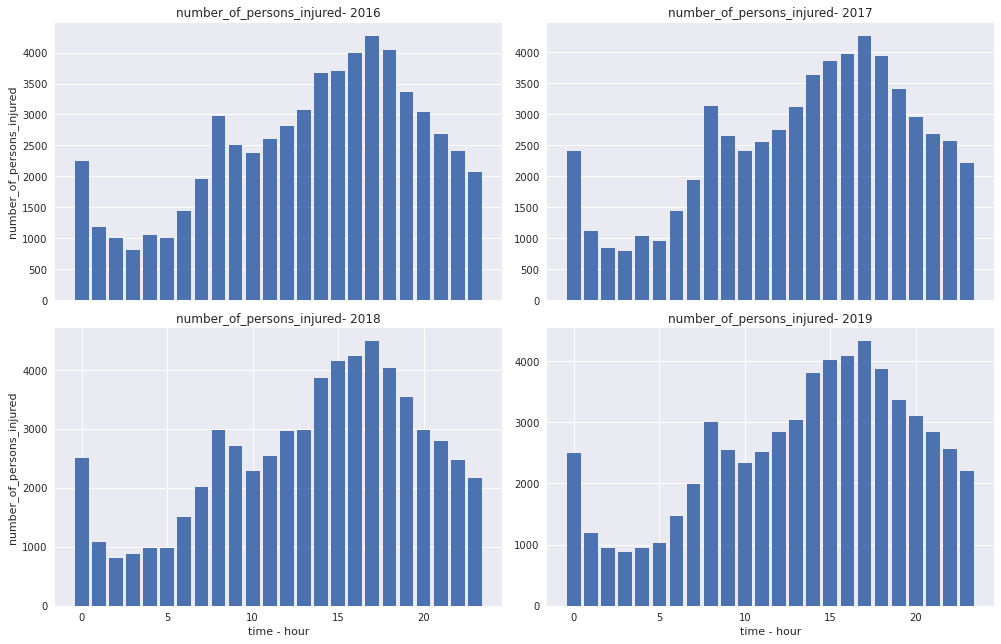

In [569]:
crashes_hr = crashes.groupby(['year','hr'])['number_of_persons_injured', 'number_of_persons_killed'].sum().reset_index()

crashes_hr = crashes_hr.sort_values(by='hr')
def bar_chart(data,col):
    df = data.copy()
    fig, ax = plt.subplots(2,2, figsize=(15,10))
    
    for i in range(2):
        for j in range(2):
            year = 2016 + i*2 +j
            ax[i,j].bar('hr', col, data=df[df['year'] == year])
            
            ax[i,j].set_title(col + '- '+ str(year))
            if i ==0:
                ax[i, j].set_xticks([])
            elif i == 1:
                ax[i,j].set_xlabel('time - hour')
            if j == 0:
                ax[i, j].set_ylabel(col)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.style.use('seaborn')    
bar_chart(crashes_hr, 'number_of_persons_injured')

#### Monthly trend of crashes/fatality in NYC

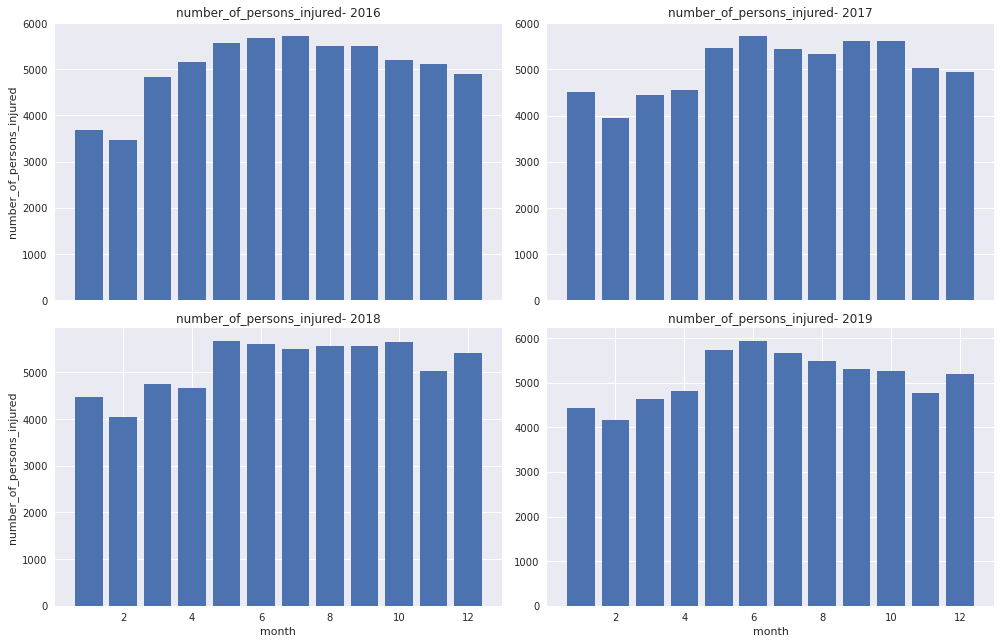

In [39]:
crashes_month = crashes.groupby(['year','month'])['number_of_persons_injured', 'number_of_persons_killed'].sum().reset_index()

def bar_chart(data,col):
    df = data.copy()
    fig, ax = plt.subplots(2,2, figsize=(15,10))
    
    for i in range(2):
        for j in range(2):
            year = 2016 + i*2 +j
            ax[i,j].bar('month', col, data=df[df['year'] == year])
            
            ax[i,j].set_title(col + '- '+ str(year))
            if i ==0:
                ax[i, j].set_xticks([])
            else:
                ax[i,j].set_xlabel('month')
            if j == 0:
                ax[i, j].set_ylabel(col)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
      

bar_chart(crashes_month, 'number_of_persons_injured')

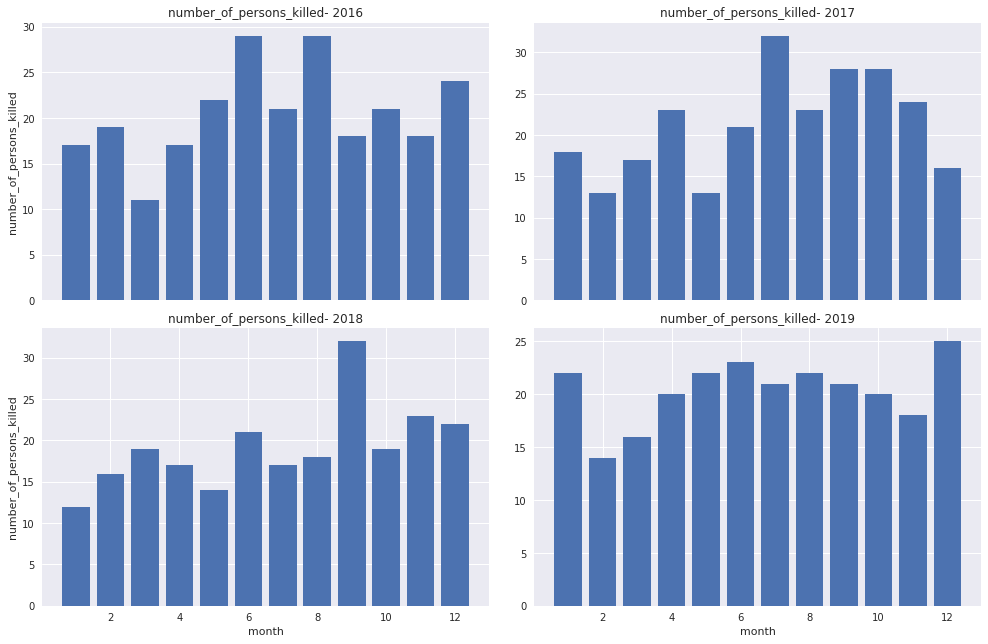

In [40]:
bar_chart(crashes_month, 'number_of_persons_killed')

#### ClusterMarker map for crashes in NYC in 2018

In [44]:
# Dropping the NA lat/long columns for now
# visualize_data_mcgroup('New York', crashes[crashes['year'] == 2019])

#### ClusterMarker map for crashes in NYC in 2019

In [ ]:
# visualize_data_mcgroup('New York', crashes[crashes['crash_date_yr'] == 2019])

#### Contributing factor wise collision distribution

In [46]:
title = 'contributing factor wise collision distribution'
crashes_rootCause = crashes.groupby('contributing_factor_vehicle_1')['collision_id']   \
                        .count().reset_index()                                         \
                        .sort_values('collision_id', ascending=False).reset_index(drop=True).head(26)

crashes_rootCause = crashes_rootCause.drop(0)
col_order = crashes_rootCause.collision_id.sort_values(ascending=False).to_list()

bar = draw_bar_col(crashes_rootCause, 'contributing_factor_vehicle_1','collision_id')
text = draw_text(crashes_rootCause, 'contributing_factor_vehicle_1','collision_id')
(bar +text).properties(width=750,height=300, title=title)

alt.LayerChart(...)

In [47]:
title = 'Monthly distribution of collision in NYC'
crashes_month = crashes.groupby('month')['collision_id'].count().reset_index()
col_order = crashes_month.collision_id.sort_values(ascending=False).to_list()

bar = draw_bar(crashes_month, 'month','collision_id')
text = draw_text(crashes_month, 'month','collision_id')
(bar + text).properties(width=400,height=300, title=title)

alt.LayerChart(...)

In [48]:
title = 'Zipcode wise distribution of collision in NYC'
crashes_zipcode = crashes.groupby('zip_code')['collision_id'].count().sort_values(ascending=False).reset_index().head(30)
mask = crashes_zipcode['zip_code'] != '_Missing_'
col_order = crashes_zipcode.collision_id.sort_values(ascending=False).to_list()

bar = draw_bar_col(crashes_zipcode[mask], 'zip_code','collision_id')
text = draw_text(crashes_zipcode[mask], 'zip_code','collision_id')
(bar + text).properties(width=800,height=300, title=title)

alt.LayerChart(...)

In [49]:
title = 'Borough wise distribution of collision in NYC'
crashes_bor = crashes.groupby('borough')['collision_id'].count().sort_values(ascending=False).reset_index()
mask = crashes_bor['borough'] != '_Missing_'
col_order = crashes_bor.collision_id.sort_values(ascending=False).to_list()

bar = draw_bar_col(crashes_bor[mask], 'borough','collision_id')
text = draw_text(crashes_bor[mask], 'borough','collision_id')
(bar + text).properties(width=400,height=300, title=title)

alt.LayerChart(...)

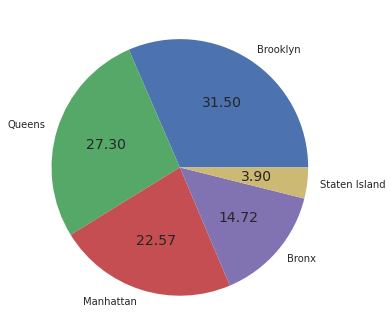

In [50]:
crashes_bor = crashes_bor[mask].reset_index(drop=True)
plt.pie(crashes_bor['collision_id'], labels=crashes_bor['borough'], autopct='%1.2f')
plt.show()

#### Geo-processing of crashes dataset

In [972]:
crashes_gdf = geo_preprocessing(crashes)
# del crashes
crashes_gdf.head(3)

cols_to_drop = ['crash_time', 'zip_code', 'location', 'month', 'hr']
crashes_gdf = crashes_gdf.drop(columns=cols_to_drop)

  0%|          | 0/1003236 [00:00<?, ?it/s]

In [990]:
%%time
# Get link information to be able to merge it with traffic speed dataset
# Here we are checking if crash location was on a particular polyline by checking if crash location(lat/long) was between 
# max/min lat/long of all the polylines(link) available 
def get_linkInfo(row, linkinfo):
    linkId_values = linkinfo.linkId.values
    lat_max_values = linkinfo.lat_max.values
    lat_min_values = linkinfo.lat_min.values
    long_max_values = linkinfo.long_max.values
    long_min_values = linkinfo.long_min.values
    
    for linkId,lat_max,lat_min,long_max,long_min in zip(linkId_values,lat_max_values,lat_min_values,long_max_values,long_min_values):
        if (lat_min<= row.latitude <= lat_max) and (long_min<= row.longitude <= long_max):
            return(linkId)
    return(None)

# crashes_gdf['linkId'] = crashes_gdf.progress_apply(lambda x: get_linkInfo(x, linkinfo_df), axis=1)

# crashes_gdf = crashes_gdf.dropna(subset=['linkId'])
# crashes_gdf['linkId'] = crashes_gdf['linkId'].astype('int32')
crashes_gdf = crashes_gdf.sort_values(by='date').reset_index(drop=True)
crashes_gdf.head(3)

CPU times: user 234 ms, sys: 10.4 ms, total: 245 ms
Wall time: 242 ms


,crash_date,borough,latitude,longitude,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,collision_id,vehicle_type_code_1,vehicle_type_code_2,year,date,geometry,linkId
0,2015-01-01,Manhattan,40.729112,-74.010672,West Street,West Houston Street,_Missing_,0,0,0,...,0,Other Vehicular,Illness,3145850,Passenger Vehicle,Passenger Vehicle,2015,2015-01-01 01:00:00,POINT (-74.01067 40.72911),4616325
1,2015-01-01,Manhattan,40.749591,-74.002786,10 Avenue,West 26 Street,_Missing_,0,0,0,...,0,Illness,Unspecified,3145867,Taxi,Large Com Veh(6 Or More Tires),2015,2015-01-01 01:20:00,POINT (-74.00279 40.74959),4616337
2,2015-01-01,Manhattan,40.757701,-73.969394,3 Avenue,East 53 Street,_Missing_,1,0,0,...,0,Failure To Yield Right-Of-Way,_Missing_,3145870,Passenger Vehicle,_Missing_,2015,2015-01-01 01:30:00,POINT (-73.96939 40.75770),4616329


In [992]:
# crashes_gdf.info()

### Traffic speeds dataset exploration/preprocessing

In [993]:
def traffic_speed_processing(data):
    df = data.copy()
    col_dtype = {'Speed':np.float16, 'TravelTime':np.int16, 'linkId': np.int32}    
    df = df[df['linkId'] != 'linkId'] 
    df['speed_date'] = pd.to_datetime(df['DataAsOf'])  
    df = df.sort_values(by='speed_date')
    df = df.drop(columns=['DataAsOf'])
    df = df.astype(col_dtype)    
    return(df)

def traffic_speed_crash_relation(crashes_gdf, years, bins):
    frames = [None] * len(years)
    for indx, year in enumerate(years):
        traffic_speed_yr = read_traffic_speed_data(ASSETS_PATH, year)
        traffic_speed_yr = traffic_speed_processing(traffic_speed_yr)
        frames[indx] = pd.merge_asof(crashes_gdf, traffic_speed_yr, left_on=['date'], \
                                              right_on=['speed_date'], by='linkId',
                                                tolerance=pd.Timedelta('5min'))

        frames[indx] = frames[indx].dropna(subset=['linkId', 'Speed'])
    frames = [frame for frame in frames if frame is not None]
    crahes_speed_df = pd.concat(frames)
    crahes_speed_df['speed_bin'] = pd.cut(crahes_speed_df['Speed'], bins=bins)
    return(crahes_speed_df)
    
def traffic_speed_crash_grp_metric(crashes_speed):
    crahes_speed_grpd = crashes_speed.groupby(['speed_bin']).agg({'number_of_persons_injured': np.sum,'number_of_persons_killed': np.sum,
                                        'number_of_pedestrians_injured':np.sum,'number_of_pedestrians_killed':np.sum,
                                        'number_of_cyclist_injured':np.sum,'number_of_cyclist_killed':np.sum,  
                                        'number_of_motorist_injured':np.sum,'number_of_motorist_killed':np.sum,  
                                        'collision_id':'count','Speed': 'mean'}).reset_index()
    
    cols_to_norm = ['number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed']
    for col in cols_to_norm:
            crahes_speed_grpd[col + '_norm'] = crahes_speed_grpd.apply(lambda row: row[col] * 100/(row.collision_id + 1)
                                                    , axis=1).astype('int16')            
    crahes_speed_grpd['speed_upper'] = crahes_speed_grpd.speed_bin.apply(lambda x: x.right).astype('int16')
    crahes_speed_grpd = crahes_speed_grpd.dropna(subset=['Speed'])
    crahes_speed_grpd['Speed'] = crahes_speed_grpd.Speed.astype('int16')    
    return(crahes_speed_grpd)

def multiline_plot(data, category, num_col, title='', xlabel=''):
    plt.figure(figsize=(10,6))
    for col in num_col:
        plt.plot(category, col, data=data, label=col.replace('_', ' '))
    plt.legend()
    plt.ylabel('count of injured', size=13)
    plt.xlabel('Speed in miles/hr', size=13)
    plt.title(title, size=17)
    plt.show()

bins = [-np.inf] + [num for num in range(0, 140, 5)]

#### Speed vs injury/fatality relation - 2015

In [996]:
# Include in then pipeline
# crashes_gdf = crashes_gdf.dropna(subset=['linkId'])
# crashes_gdf['linkId'] = crashes_gdf['linkId'].astype('int32')
crashes_gdf.year.value_counts()

2017    43731
2018    42658
2016    38661
2015    38258
2019    36907
Name: year, dtype: int64

In [997]:
years = [2015]
crahes_speed_2015 = traffic_speed_crash_relation(crashes_gdf, years, bins)
crash_speed_2015_grp = traffic_speed_crash_grp_metric(crahes_speed_2015)
crash_speed_2015_grp.head(3)

,speed_bin,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,collision_id,Speed,number_of_persons_injured_norm,number_of_persons_killed_norm,number_of_pedestrians_injured_norm,number_of_pedestrians_killed_norm,number_of_cyclist_injured_norm,number_of_cyclist_killed_norm,number_of_motorist_injured_norm,number_of_motorist_killed_norm,speed_upper
1,"(0.0, 5.0]",113,0,23,0,12,0,78,0,625,3,18,0,3,0,1,0,12,0,5
2,"(5.0, 10.0]",366,1,92,0,61,1,213,0,1996,8,18,0,4,0,3,0,10,0,10
3,"(10.0, 15.0]",507,2,106,2,82,0,319,0,2670,13,18,0,3,0,3,0,11,0,15


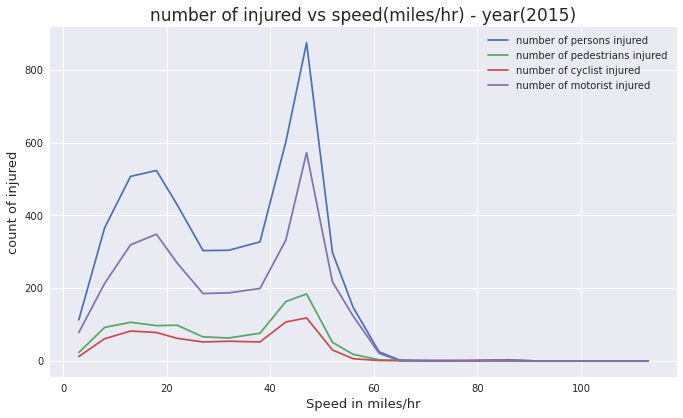

In [998]:
injrd_cols_to_lineplot = ['number_of_persons_injured', 'number_of_pedestrians_injured',    \
                    'number_of_cyclist_injured', 'number_of_motorist_injured']
year = 2015
title = 'number of injured vs speed(miles/hr) - year(' + str(year) + ')'
crash_plt = multiline_plot(crash_speed_2015_grp, 'Speed', injrd_cols_to_lineplot, title=title, xlabel='')

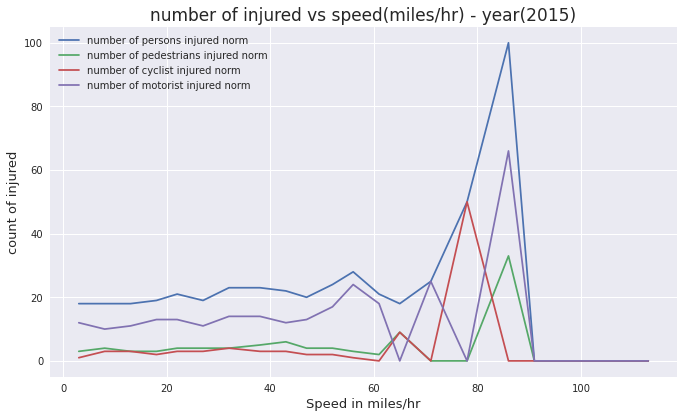

In [999]:
year = 2015
title = 'number of injured vs speed(miles/hr) - year(' + str(year) + ')'
multiline_plot(crash_speed_2015_grp, 'Speed', injrd_norm_cols_to_lineplot, title=title, xlabel='')

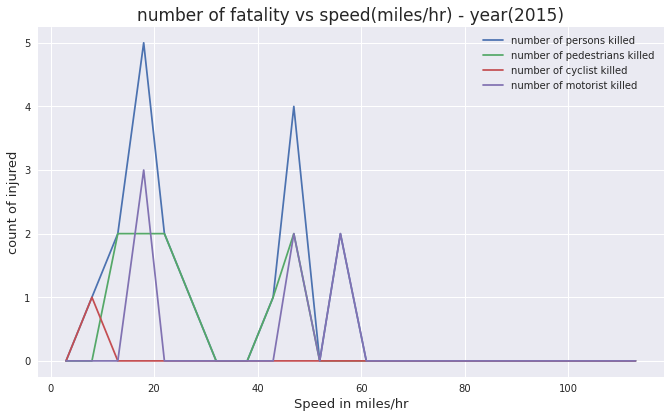

In [1002]:
year = 2015
title = 'number of fatality vs speed(miles/hr) - year(' + str(year) + ')'
multiline_plot(crash_speed_2015_grp, 'Speed', killed_cols_to_lineplot, title=title, xlabel='')

In [1003]:
# killed_norm_cols_to_lineplot = ['number_of_persons_killed_norm', 'number_of_pedestrians_killed_norm',    \
#                     'number_of_cyclist_killed_norm', 'number_of_motorist_killed_norm']
# year = 2015
# title = 'number of fatality vs speed(miles/hr) - year(' + str(year) + ')'
# fatal_plt = multiline_plot(crash_speed_2015_grp, 'Speed', killed_norm_cols_to_lineplot, title=title, xlabel='')

#### Speed vs injury/fatality relation - 2016

In [1004]:
years = [2016]
crahes_speed_2016 = traffic_speed_crash_relation(crashes_gdf, years, bins)
crash_speed_2016_grp = traffic_speed_crash_grp_metric(crahes_speed_2016)
crash_speed_2016_grp.head(3)

,speed_bin,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,collision_id,Speed,number_of_persons_injured_norm,number_of_persons_killed_norm,number_of_pedestrians_injured_norm,number_of_pedestrians_killed_norm,number_of_cyclist_injured_norm,number_of_cyclist_killed_norm,number_of_motorist_injured_norm,number_of_motorist_killed_norm,speed_upper
0,"(-inf, 0.0]",0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
1,"(0.0, 5.0]",253,0,57,0,37,0,158,0,1203,3,21,0,4,0,3,0,13,0,5
2,"(5.0, 10.0]",620,2,127,2,80,0,413,0,3059,8,20,0,4,0,2,0,13,0,10


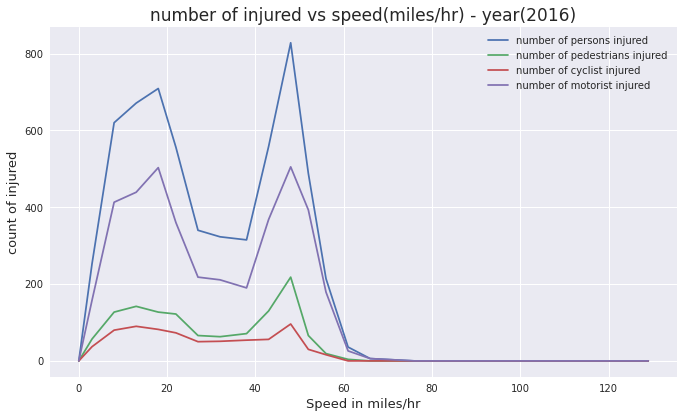

In [1005]:
year = 2016
title = 'number of injured vs speed(miles/hr) - year(' + str(year) + ')'
multiline_plot(crash_speed_2016_grp, 'Speed', injrd_cols_to_lineplot, title=title, xlabel='')

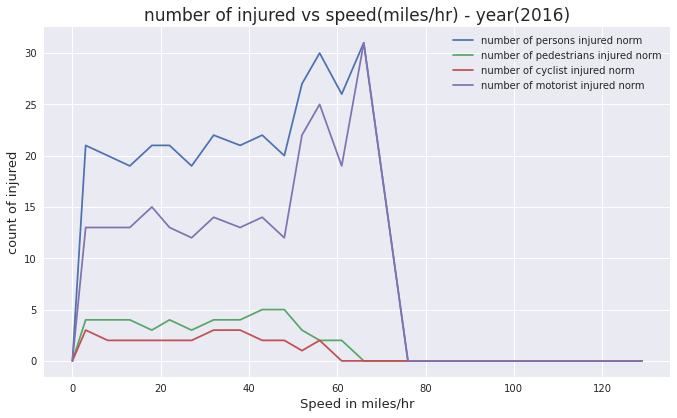

In [1006]:
year = 2016
title = 'number of injured vs speed(miles/hr) - year(' + str(year) + ')'
multiline_plot(crash_speed_2016_grp, 'Speed', injrd_norm_cols_to_lineplot, title=title, xlabel='')

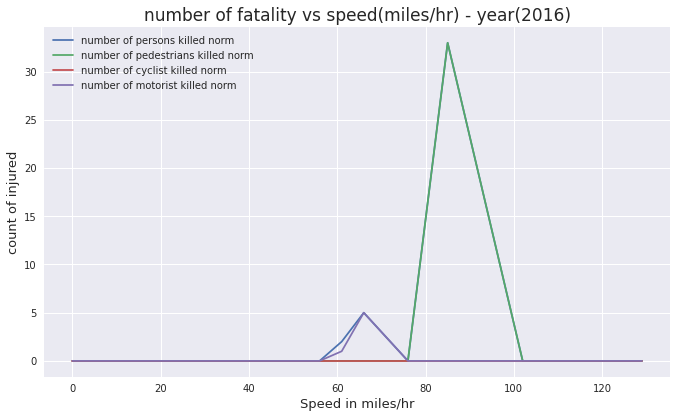

In [1007]:
title = 'number of injured vs speed(miles/hr) - year(' + str(year) + ')'

year = 2016
title = 'number of fatality vs speed(miles/hr) - year(' + str(year) + ')'
multiline_plot(crash_speed_2016_grp, 'Speed', killed_norm_cols_to_lineplot, title=title, xlabel='')

In [1008]:
years = [2015, 2016, 2017, 2018, 2019]
crahes_speed_years = traffic_speed_crash_relation(crashes_gdf, years, bins)
crahes_speed_years_grp = traffic_speed_crash_grp_metric(crahes_speed_years)
crahes_speed_years_grp.head(3)

,speed_bin,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,collision_id,Speed,number_of_persons_injured_norm,number_of_persons_killed_norm,number_of_pedestrians_injured_norm,number_of_pedestrians_killed_norm,number_of_cyclist_injured_norm,number_of_cyclist_killed_norm,number_of_motorist_injured_norm,number_of_motorist_killed_norm,speed_upper
0,"(-inf, 0.0]",1976,10,365,6,178,2,1431,2,8249,0,23,0,4,0,2,0,17,0,0
1,"(0.0, 5.0]",649,2,119,1,59,0,469,1,3085,3,21,0,3,0,1,0,15,0,5
2,"(5.0, 10.0]",2293,13,510,9,276,4,1508,0,10939,8,20,0,4,0,2,0,13,0,10


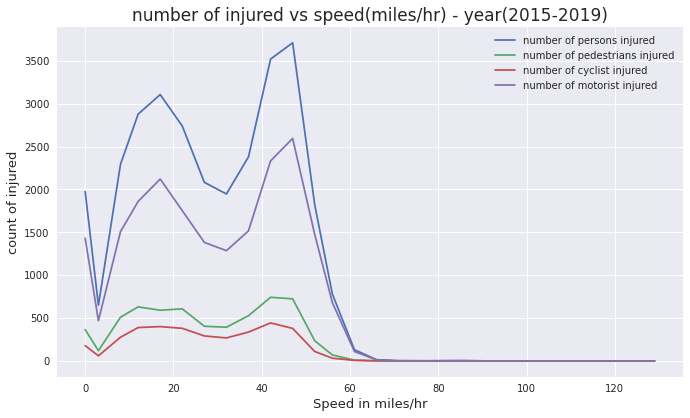

In [1010]:
title = 'number of injured vs speed(miles/hr) - year(' + str(years[0]) + '-'  + str(years[-1]) + ')'
multiline_plot(crahes_speed_years_grp, 'Speed', injrd_cols_to_lineplot, title=title, xlabel='')

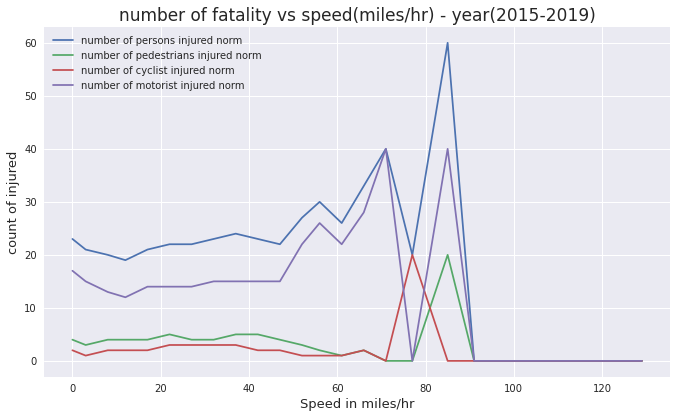

In [1011]:
title = 'number of fatality vs speed(miles/hr) - year(' + str(years[0]) + '-'  + str(years[-1]) + ')'
multiline_plot(crahes_speed_years_grp, 'Speed', injrd_norm_cols_to_lineplot, title=title, xlabel='')

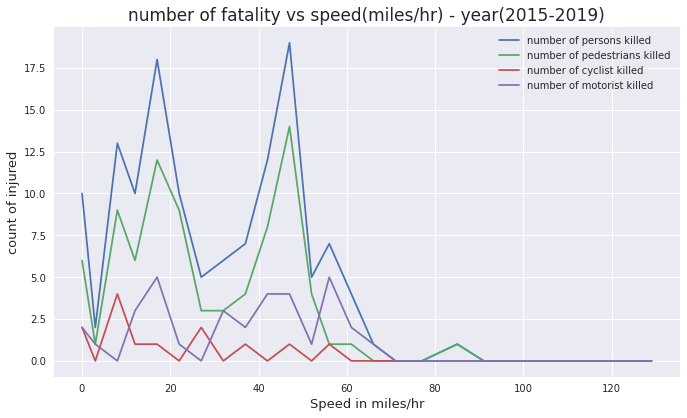

In [1012]:
title = 'number of fatality vs speed(miles/hr) - year(' + str(years[0]) + '-'  + str(years[-1]) + ')'
multiline_plot(crahes_speed_years_grp, 'Speed', killed_cols_to_lineplot, title=title, xlabel='')

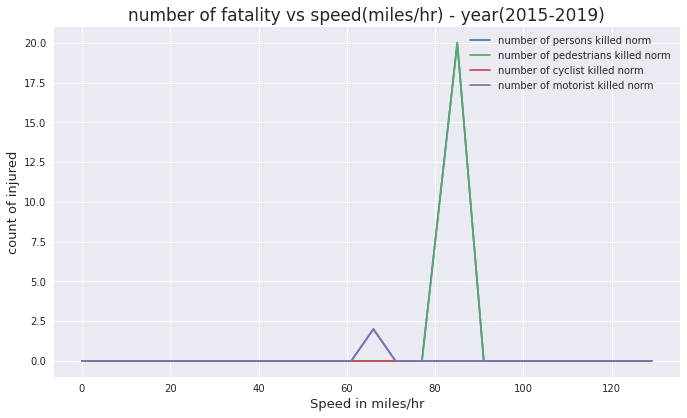

In [1013]:
title = 'number of fatality vs speed(miles/hr) - year(' + str(years[0]) + '-'  + str(years[-1]) + ')'
multiline_plot(crahes_speed_years_grp, 'Speed', killed_norm_cols_to_lineplot, title=title, xlabel='')

In [1026]:
stats.pearsonr(crahes_speed_grpd['Speed'], crahes_speed_grpd['number_of_persons_injured'])

(-0.3026742224434438, 0.19458896691260738)

In [1025]:
stats.ttest_ind(crahes_speed_grpd['Speed'], crahes_speed_grpd['number_of_persons_injured'])

Ttest_indResult(statistic=-3.3302343382358406, pvalue=0.0019388680302365987)

In [1024]:
stats.pearsonr(crahes_speed_grpd['Speed'], crahes_speed_grpd['number_of_persons_killed'])

(-0.33665708880938305, 0.14666876217552455)

In [1023]:
stats.ttest_ind(crahes_speed_grpd['Speed'], crahes_speed_grpd['number_of_persons_killed'])

Ttest_indResult(statistic=1.3488498874440031, pvalue=0.18536892098828092)

### Explore top roads in terms of crashes/fatality monitored by cctv

In [1027]:
def crash_speed_link_relation(crashes, years):
    frames = [None] * len(years)
    crash_gdf = crashes.copy()
    for indx,year in enumerate(years):
        traffic_speed_yr = read_traffic_speed_data(ASSETS_PATH, year)
        traffic_speed_yr = traffic_speed_processing(traffic_speed_yr)

        crahes_speed_yr = pd.merge_asof(crash_gdf, traffic_speed_yr, left_on=['date'], \
                                          right_on=['speed_date'], by='linkId',                                    
                                            tolerance=pd.Timedelta('5min'))
        
        frames[indx] = crahes_speed_yr.groupby(['linkId']).agg({'number_of_persons_injured': np.sum,'number_of_persons_killed': np.sum,
                                            'number_of_pedestrians_injured':np.sum,'number_of_pedestrians_killed':np.sum,
                                            'number_of_cyclist_injured':np.sum,'number_of_cyclist_killed':np.sum,  
                                            'number_of_motorist_injured':np.sum,'number_of_motorist_killed':np.sum,  
                                            'collision_id':'count','Speed': 'mean'}).reset_index()
        
    frames = [frame for frame in frames if frame is not None]
    crahes_speed_grpd = pd.concat(frames)
    crahes_speed_grpd = crahes_speed_grpd.groupby(['linkId']).agg({'number_of_persons_injured': np.sum,'number_of_persons_killed': np.sum,
                                            'number_of_pedestrians_injured':np.sum,'number_of_pedestrians_killed':np.sum,
                                            'number_of_cyclist_injured':np.sum,'number_of_cyclist_killed':np.sum,  
                                            'number_of_motorist_injured':np.sum,'number_of_motorist_killed':np.sum,  
                                            'collision_id':'count','Speed': 'mean'}).reset_index()
    return(crahes_speed_grpd)

In [1028]:
years = [2019]
crahes_speed_grpd_yr = crash_speed_link_relation(crashes_gdf, years) 

title = 'number of persons injured in NYC:' + str(year)
crahes_speed_grpd_yr = crahes_speed_grpd_yr.sort_values(by='number_of_persons_injured',ascending=False) \
                                    .reset_index(drop=True).head(20)
col_order = crahes_speed_grpd_yr.number_of_persons_injured.sort_values(ascending=False).to_list()

bar = draw_bar_col(crahes_speed_grpd_yr, 'linkId','number_of_persons_injured')
text = draw_text(crahes_speed_grpd_yr, 'linkId','number_of_persons_injured')
(bar + text).properties(width=800,height=300, title=title)

alt.LayerChart(...)

In [873]:
years = [2015, 2016, 2017, 2018, 2019]
# crahes_speed_grpd = crash_speed_link_relation(crashes_gdf, years) 

title = 'number of persons injured in NYC'
crahes_speed_grpd = crahes_speed_grpd.sort_values(by='number_of_persons_injured',ascending=False).reset_index(drop=True).head(20)
col_order = crahes_speed_grpd.number_of_persons_injured.sort_values(ascending=False).to_list()

bar = draw_bar_col(crahes_speed_grpd, 'linkId','number_of_persons_injured')
text = draw_text(crahes_speed_grpd, 'linkId','number_of_persons_injured')
(bar + text).properties(width=800,height=300, title=title)

alt.LayerChart(...)

In [461]:
title = 'number of persons killed in NYC'
crahes_speed_grpd = crahes_speed_grpd.sort_values(by='number_of_persons_killed',ascending=False).reset_index(drop=True).head(20)
col_order = crahes_speed_grpd.number_of_persons_killed.sort_values(ascending=False).to_list()

bar = draw_bar_col(crahes_speed_grpd, 'linkId','number_of_persons_killed')
text = draw_text(crahes_speed_grpd, 'linkId','number_of_persons_killed')
(bar + text).properties(width=800,height=300, title=title)

alt.LayerChart(...)

In [1065]:
# crahes_speed_grpd_poly.head(3)

In [1029]:
crahes_speed_grpd_poly = pd.merge(crahes_speed_grpd_yr, linkinfo_df, on='linkId', how='inner')
crahes_speed_grpd_poly = crahes_speed_grpd_poly.sort_values(by='number_of_persons_killed',ascending=False).reset_index(drop=True).head(20)
crahes_speed_grpd_poly.head(4)

,linkId,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,collision_id,Speed,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Borough,lat_max,lat_min,long_max,long_min,linkPointsDecoded
0,4620343,9375,49,2514,35,1446,4,5401,10,1,30.796875,"40.77149,-73.99423 40.7719,-73.99401 40.77481,...",ydzwF|~rbMqAk@eQyKkUkOyHiFgGgFyPaLgJ{FgJ_D}IsC...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...,Manhattan,40.84983,40.77149,-73.94319,-73.99423,ydzwF|~rbMqAk@eQyKkUkOyHiFgGgFyPaLgJ{FgJ_D}IsC...
1,4616257,7607,23,1475,12,1182,3,4945,8,1,21.093750,"40.69153,-73.99911 40.6922605,-73.99937 40.692...",aqjwFl}sbMqCr@}B?yAWoCu@{DyAyM_F{KeEcAk@iAgA}@...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...,Brooklyn,40.71759,40.69153,-73.94829,-73.99911,aqjwFl}sbMqCr@}B?yAWoCu@{DyAyM_F{KeEcAk@iAgA}@...
2,4616255,4357,18,678,13,253,0,3415,5,1,26.812500,"40.81376,-73.93128 40.8127206,-73.9316 40.8121...",_mbxFnufbMnE~@xBP|BOpBeA|A}ArLaQjBgElFiQjHiVvF...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,Bronx,40.82408,40.80339,-73.87432,-73.91503,_mbxFnufbMnE~@xBP|BOpBeA|A}ArLaQjBgElFiQjHiVvF...
3,4616235,1333,12,92,4,82,2,1157,6,1,19.546875,"40.69153,-73.99911 40.6922605,-73.99937 40.692...",}sowFx_jbMwDgHuHgOgG}LqBkDmB}CeCeFoD{Hg@qAcAgG...,BBBBBBBBBBBBBBBBBBBBBBBBBB,Brooklyn,40.73499,40.71759,-73.92024,-73.94829,}sowFx_jbMwDgHuHgOgG}LqBkDmB}CeCeFoD{Hg@qAcAgG...


#### Plot link polyline for high crashes/fatality

In [1053]:

linkinfo_df[linkinfo_df['linkId'] == linkId]

,linkId,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Borough,lat_max,lat_min,long_max,long_min,linkPointsDecoded
143,4620343,"40.77149,-73.99423 40.7719,-73.99401 40.77481,...",ydzwF|~rbMqAk@eQyKkUkOyHiFgGgFyPaLgJ{FgJ_D}IsC...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...,Manhattan,40.84983,40.77149,-73.94319,-73.99423,ydzwF|~rbMqAk@eQyKkUkOyHiFgGgFyPaLgJ{FgJ_D}IsC...


In [1054]:
enc_poly = linkinfo_df[linkinfo_df['linkId'] == linkId].EncodedPolyLine.values[0]
polyline.decode(enc_poly)

[(40.77149, -73.99423),
 (40.7719, -73.99401),
 (40.77481, -73.99196),
 (40.77839, -73.98934),
 (40.77996, -73.98817),
 (40.78128, -73.98701),
 (40.78413, -73.98492),
 (40.78593, -73.98366),
 (40.78773, -73.98286),
 (40.78948, -73.98212),
 (40.79086, -73.98136),
 (40.79235, -73.98027),
 (40.79319, -73.97958),
 (40.79411, -73.97867),
 (40.79592, -73.9765),
 (40.7965, -73.97595),
 (40.79693, -73.97574),
 (40.79816, -73.97529),
 (40.80031, -73.97446),
 (40.80103, -73.97405),
 (40.80257, -73.97299),
 (40.80565, -73.9707),
 (40.80785, -73.96901),
 (40.8114, -73.96663),
 (40.81303, -73.96533),
 (40.81396, -73.96474),
 (40.81512, -73.96411),
 (40.81562, -73.96374),
 (40.81616, -73.96332),
 (40.81694, -73.96261),
 (40.81835, -73.96115),
 (40.81906, -73.96051),
 (40.82026, -73.95945),
 (40.8213, -73.95856),
 (40.82315, -73.95715),
 (40.82468, -73.95594),
 (40.8271, -73.9537),
 (40.82913, -73.95185),
 (40.82978, -73.9514),
 (40.83054, -73.95097),
 (40.83208, -73.95039),
 (40.83467, -73.94962),
 

In [1035]:
crashes_gdf[crashes_gdf['linkId'] == linkId].head(3)

,crash_date,borough,latitude,longitude,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,collision_id,vehicle_type_code_1,vehicle_type_code_2,year,date,geometry,linkId
4,2015-01-01,Manhattan,40.792933,-73.947901,East 106 Street,Park Avenue,_Missing_,0,0,0,...,0,Illness,_Missing_,3146198,Taxi,Sport Utility / Station Wagon,2015,2015-01-01 01:30:00,POINT (-73.94790 40.79293),4620343
6,2015-01-01,Manhattan,40.783026,-73.982126,West End Avenue,West 77 Street,_Missing_,0,0,0,...,0,Driver Inattention/Distraction,Unspecified,3146191,Pick-Up Truck,Passenger Vehicle,2015,2015-01-01 01:40:00,POINT (-73.98213 40.78303),4620343
8,2015-01-01,Manhattan,40.832766,-73.945824,West 155 Street,Broadway,_Missing_,0,0,0,...,0,Unspecified,Unspecified,3145904,Passenger Vehicle,Taxi,2015,2015-01-01 02:35:00,POINT (-73.94582 40.83277),4620343


In [1056]:
def draw_polyline_link_crashes(data,linkinfo_df, linkId):
    crashes_df = data.copy()
    crashes_df = crashes_df[crashes_df['linkId'] == linkId]
    enc_poly = linkinfo_df[linkinfo_df['linkId'] == linkId].EncodedPolyLine.values[0]
    line = polyline.decode(enc_poly)
    coords = [[p[0] ,p[1]] for p in line ]
    coords_mid = coords[len(coords)//2]

    m = folium.Map(location=coords_mid,zoom_start = 13)
    folium.PolyLine(locations=line).add_to(m)
    for point in coords:
        folium.Marker(location=point).add_to(m)
    crash_coords = crashes_df.geometry.values[:5]
    for point in crash_coords:
        folium.Marker(location=[point.y, point.x], popup='crash_point').add_to(m)
    return(m)
linkId = crahes_speed_grpd_yr.linkId.values[1]
m = draw_polyline_link_crashes(crashes_gdf, linkinfo_df, linkId)
m

In [724]:
def draw_polyline(enc_poly):
    line = polyline.decode(enc_poly)
    coords = [[p[0] ,p[1]] for p in line ]
    coords_mid = coords[len(coords)//2]

    m = folium.Map(location=coords_mid,zoom_start = 14)
    folium.PolyLine(locations=line).add_to(m)
    for point in coords:
        folium.Marker(location=point).add_to(m)
    return(m)

m = draw_polyline(linkinfo_df['EncodedPolyLine'][30])
m

In [609]:
m = draw_polyline(linkinfo_df['EncodedPolyLine'][30])
m

#### Explore death rate/average licence cost in different contries

In [568]:
col_order = driving_cost['LicenseCostAvg'].sort_values(ascending=False).to_list()
bar = draw_bar(driving_cost, 'Country','LicenseCostAvg', title='')
text = draw_text(driving_cost, 'Country','LicenseCostAvg', title='')
(bar + text).properties(width=700,height=300, title='Driving Cost in Countries(in dollers)')

alt.LayerChart(...)

In [67]:
driving_cost_death_rate = driving_cost.merge(crash_death_rate, left_on='Country', right_on='country', how='left')
driving_cost_death_rate = driving_cost_death_rate.drop(columns=['country', 'continent'])
driving_cost_death_rate.iloc[:, [1,2,3]] = driving_cost_death_rate.iloc[:, [1,2,3]].apply(lambda x: x.astype('float'))
driving_cost_death_rate['license_cost_lg'] = driving_cost_death_rate['LicenseCostAvg']  \
                                                    .apply(lambda x: np.log(x))
driving_cost_death_rate['death_rate_habitant_lg'] = driving_cost_death_rate['death_rate(per_lacs_habitant_per_year)']  \
                                                    .apply(lambda x: np.log(x))
driving_cost_death_rate['death_rate_vehicle_lg'] = driving_cost_death_rate['death_rate(per_lacs_vehicle_per_year)']  \
                                                    .apply(lambda x: np.log(x))
driving_cost_death_rate = driving_cost_death_rate.dropna()
driving_cost_death_rate.head()

,Country,LicenseCostAvg,death_rate(per_lacs_habitant_per_year),death_rate(per_lacs_vehicle_per_year),license_cost_lg,death_rate_habitant_lg,death_rate_vehicle_lg
1,United States,510.00,12.4,14.2,6.234411,2.517696,2.653242
2,Canada,67.00,5.8,8.9,4.204693,1.757858,2.186051
3,Russia,577.00,11.6,50.0,6.357842,2.451005,3.912023
5,India,9.59,16.6,130.1,2.260721,2.809403,4.868303
6,Spain,1575.50,3.7,5.8,7.362328,1.308333,1.757858


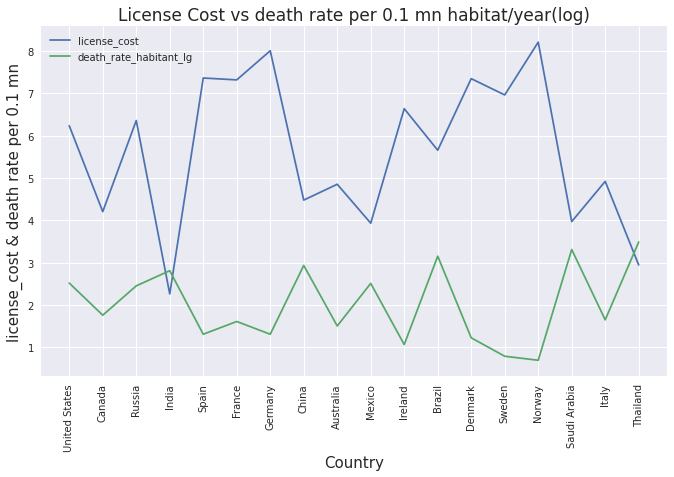

In [68]:
plt.figure(figsize=(10,6))
plt.plot(driving_cost_death_rate['Country'], driving_cost_death_rate['license_cost_lg'], label='license_cost')
plt.plot(driving_cost_death_rate['Country'], driving_cost_death_rate['death_rate_habitant_lg'], label='death_rate_habitant_lg')
plt.xticks(rotation=90)
plt.xlabel('Country', size=15)
plt.ylabel('license_cost & death rate per 0.1 mn', size=15)
plt.title('License Cost vs death rate per 0.1 mn habitat/year(log)', size=17)
plt.legend()
plt.show()

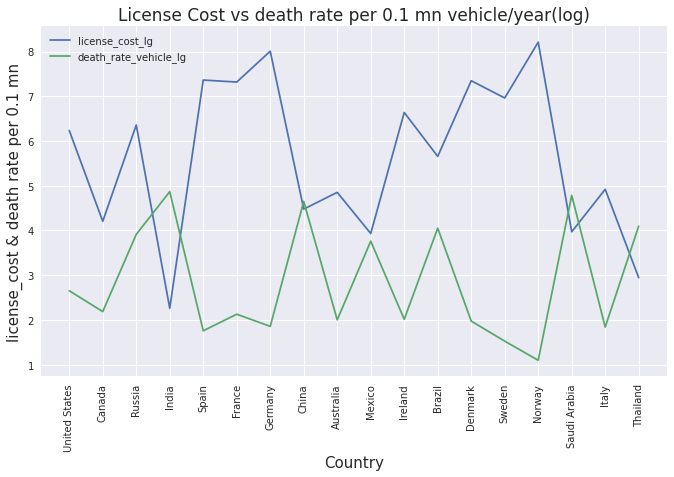

In [69]:
plt.figure(figsize=(10,6))
plt.plot(driving_cost_death_rate['Country'], driving_cost_death_rate['license_cost_lg'], label='license_cost_lg')
plt.plot(driving_cost_death_rate['Country'], driving_cost_death_rate['death_rate_vehicle_lg'], label='death_rate_vehicle_lg')
plt.xticks(rotation=90)
plt.xlabel('Country', size=15)
plt.ylabel('license_cost & death rate per 0.1 mn', size=15)
plt.title('License Cost vs death rate per 0.1 mn vehicle/year(log)', size=17)
plt.legend()
plt.show()

In [70]:
stats.pearsonr(driving_cost_death_rate['LicenseCostAvg'], driving_cost_death_rate['death_rate(per_lacs_habitant_per_year)'])

(-0.5488954373932361, 0.01832106812896289)

In [71]:
stats.pearsonr(driving_cost_death_rate['LicenseCostAvg'], driving_cost_death_rate['death_rate(per_lacs_vehicle_per_year)'])

(-0.5018273962959141, 0.03383974539906066)

#### There is moderate negative correlation between license cost and death rate per lacs habitat as well as vehicle per year.

Lets do a hypothesis test
<br><b>Null Hypothesis</b> - Death rate is same across different average license costs.
<br><b>Alternate Hypothesis</b> - Death rate is not same across different average license cost across different contries.

Set Alpha = 0.05

In [72]:
np.set_printoptions(suppress=True)
stats.ttest_ind(driving_cost_death_rate['LicenseCostAvg'], driving_cost_death_rate['death_rate(per_lacs_habitant_per_year)'])

Ttest_indResult(statistic=3.2699832986519914, pvalue=0.0024671968283110613)

In [73]:
stats.ttest_ind(driving_cost_death_rate['LicenseCostAvg'], driving_cost_death_rate['death_rate(per_lacs_vehicle_per_year)'])

Ttest_indResult(statistic=3.16832186341643, pvalue=0.003234655694685484)

<b>p-value is less than 5%(near zero), hence we reject the null hypothesis that death rates are same over different average license cost.</b>
    
     - That is we have significant evidence that death rate varies inversaly to license cost.
    
Now this may be misleading.
<br>While there is inverse correlation between average license cost and death rate, this does not mean there is causal relationship.
But what we can say, is that perhaps more training and tests require additional cost and hence cause increase in license cost which causes reduction is traffic crashes because of more skilled drivers on the road.

### Explore traffic volume and crashes/fatality relation

In [110]:
on_street = crashes_gdf.on_street_name.value_counts().to_dict()
cross_street = crashes_gdf.cross_street_name.value_counts().to_dict()
off_street = crashes_gdf.off_street_name.value_counts().to_dict()

street_combined = Counter(on_street) + Counter(cross_street) + Counter(off_street)

del street_combined['_Missing_']
roadway_crashes = pd.DataFrame(street_combined.most_common(100), columns=['roadway_name', 'crashes_count'])
roadway_crashes['roadway_name'] = roadway_crashes['roadway_name'].apply(lambda x: x.title())
roadway_crashes.head()

,roadway_name,crashes_count
0,Broadway,16437
1,3 Avenue,15218
2,2 Avenue,11825
3,Atlantic Avenue,11256
4,Belt Parkway,9999


In [75]:
roadway_crashes_vol = roadway_crashes.merge(traffic_vol_roadway, on='roadway_name',how='inner')
roadway_crashes_vol['crashes_count_lg'] = np.log(roadway_crashes_vol['crashes_count'])
roadway_crashes_vol.head(5)

,roadway_name,crashes_count,traffic_vol,traffic_vol_lg,expressway,crashes_count_lg
0,Broadway,16437,9824.835185,9.192669,N,9.707290
1,3 Avenue,15218,12857.857520,9.461710,N,9.630234
2,2 Avenue,11825,27423.414141,10.219152,N,9.377971
3,Atlantic Avenue,11256,15690.034722,9.660781,N,9.328657
4,Belt Parkway,9999,60240.119658,11.006094,N,9.210240


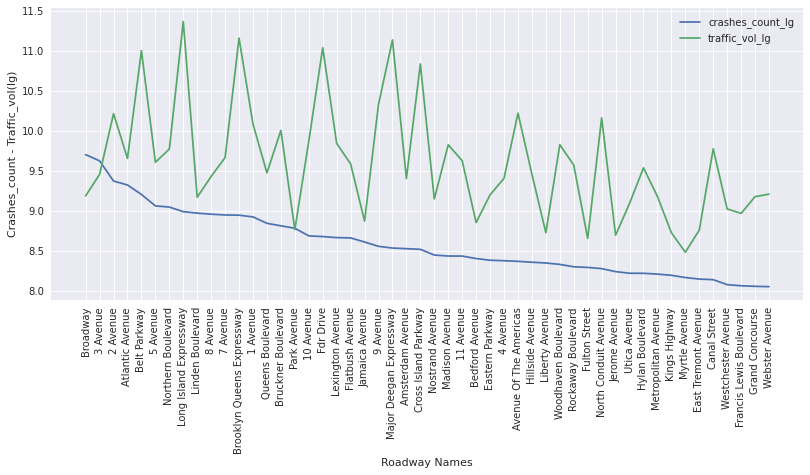

In [76]:
roadway_crashes_vol_50 = roadway_crashes_vol[:50]
plt.figure(figsize=(12,5))
plt.plot(roadway_crashes_vol_50['roadway_name'], roadway_crashes_vol_50['crashes_count_lg'], label='crashes_count_lg')
plt.plot(roadway_crashes_vol_50['roadway_name'], roadway_crashes_vol_50['traffic_vol_lg'], label='traffic_vol_lg')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Roadway Names')
plt.ylabel('Crashes_count - Traffic_vol(lg)')
plt.show()

In [77]:
stats.pearsonr(roadway_crashes_vol['crashes_count'], roadway_crashes_vol['traffic_vol'])

(0.2675852230897315, 0.009512438086292253)

In [78]:
on_street_injured = crashes_gdf.groupby('on_street_name')['number_of_persons_injured'].sum().to_dict()
cross_street_injured = crashes_gdf.groupby('cross_street_name')['number_of_persons_injured'].sum().to_dict()
off_street_injured = crashes_gdf.groupby('off_street_name')['number_of_persons_injured'].sum().to_dict()

all_injured = Counter(on_street_injured) + Counter(cross_street_injured) + Counter(off_street_injured)
del all_injured['_Missing_']
all_injured = pd.DataFrame(all_injured.most_common(500), columns=['roadway_name', 'injured_count'])
all_injured.head()

,roadway_name,injured_count
0,Broadway,4172.0
1,Belt Parkway,3904.0
2,3 Avenue,3487.0
3,Atlantic Avenue,3465.0
4,Linden Boulevard,3459.0


In [79]:
all_injured_roadway = all_injured.merge(traffic_vol_roadway, on='roadway_name', how='inner')
all_injured_roadway.head()

,roadway_name,injured_count,traffic_vol,traffic_vol_lg,expressway
0,Broadway,4172.0,9824.835185,9.192669,N
1,Belt Parkway,3904.0,60240.119658,11.006094,N
2,3 Avenue,3487.0,12857.857520,9.461710,N
3,Atlantic Avenue,3465.0,15690.034722,9.660781,N
4,Linden Boulevard,3459.0,9657.037037,9.175442,N


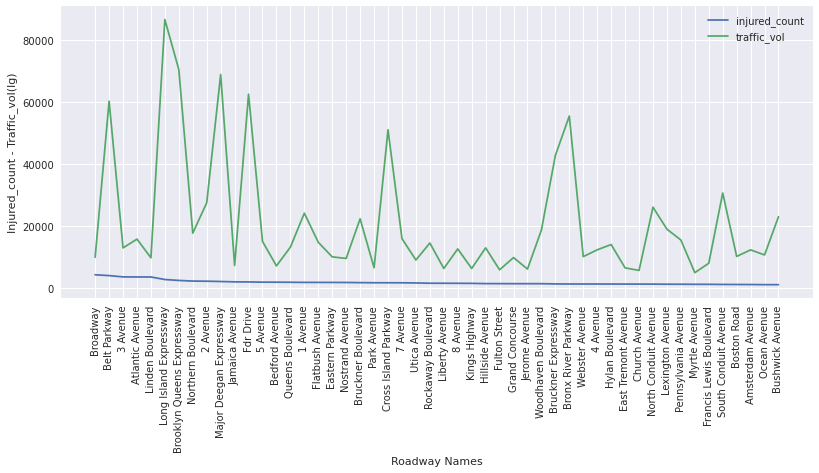

In [80]:
all_injured_roadway_50 = all_injured_roadway[:50]
plt.figure(figsize=(12,5))
plt.plot(all_injured_roadway_50['roadway_name'], all_injured_roadway_50['injured_count'], label='injured_count')
plt.plot(all_injured_roadway_50['roadway_name'], all_injured_roadway_50['traffic_vol'], label='traffic_vol')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Roadway Names')
plt.ylabel('Injured_count - Traffic_vol(lg)')
plt.show()

In [81]:
stats.pearsonr(all_injured_roadway_50['injured_count'], all_injured_roadway_50['traffic_vol'])

(0.25944552131198007, 0.06884272831769749)

In [91]:
title = 'On Street wise distribution of collision in NYC'
crashes_onStreet = crashes_gdf.groupby('on_street_name')['collision_id'].count()  \
                        .sort_values(ascending=False).reset_index()[:25]
mask = crashes_onStreet['on_street_name'] != '_Missing_'
col_order = crashes_onStreet.collision_id.sort_values(ascending=False).to_list()[:25]

bar = draw_bar(crashes_onStreet[mask], 'on_street_name','collision_id', title='')
text = draw_text(crashes_onStreet[mask], 'on_street_name','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

In [83]:
title = 'Cross Street wise distribution of collision in NYC'
crashes_crossStreet = crashes_gdf.groupby('cross_street_name')['collision_id'].count() \
                        .sort_values(ascending=False).reset_index()[:25]
mask = crashes_crossStreet['cross_street_name'] != '_Missing_'
col_order = crashes_crossStreet.collision_id.sort_values(ascending=False).to_list()[:25]


bar = draw_bar(crashes_crossStreet[mask], 'cross_street_name','collision_id', title='')
text = draw_text(crashes_crossStreet[mask], 'cross_street_name','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

In [84]:
title = 'Off-Street wise distribution of collision in NYC'
crashes_offStreet = crashes_gdf.groupby('off_street_name')['collision_id'].count()  \
                        .sort_values(ascending=False).reset_index()[:25]
mask = crashes_offStreet['off_street_name'] != '_Missing_'
col_order = crashes_offStreet.collision_id.sort_values(ascending=False).to_list()[:25]

bar = draw_bar(crashes_offStreet[mask], 'off_street_name','collision_id', title='')
text = draw_text(crashes_offStreet[mask], 'off_street_name','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

In [85]:
heat_crashes = crashes_gdf[crashes_gdf['on_street_name'] =='Belt Parkway'].groupby(['latitude', 'longitude'])['collision_id'].sum().reset_index().values.tolist()
def geo_heatmap(city, data):
    point = city_geocoder(city)
    if not point:
        print('Please check the city/county name, Thank You.')
        return

    m = folium.Map(location=[point.y, point.x], zoom_start=11)
    folium.plugins.HeatMap(data).add_to(m)
    return(m)

city = 'New York'
case_heatmap = geo_heatmap(city, heat_crashes)
case_heatmap

In [86]:
heat_crashes = crashes_gdf[crashes_gdf['on_street_name'] =='Broadway'].groupby(['latitude', 'longitude'])['collision_id'].sum().reset_index().values.tolist()
def geo_heatmap(city, data):
    point = city_geocoder(city)
    if not point:
        print('Please check the city/county name, Thank You.')
        return

    m = folium.Map(location=[point.y, point.x], zoom_start=11)
    folium.plugins.HeatMap(data).add_to(m)
    return(m)

city = 'BROADWAY'
case_heatmap = geo_heatmap(city, heat_crashes)
case_heatmap

In [87]:
title = 'Contributing factor wise distribution of collision in NYC at "BELT PARKWAY" street'
crashes_onStreet = crashes_gdf[crashes_gdf['on_street_name'] == 'Belt Parkway'].groupby('contributing_factor_vehicle_1') \
                        ['collision_id'].count().sort_values(ascending=False).reset_index()[:10]
col_order = crashes_onStreet.collision_id.sort_values(ascending=False).to_list()[:10]

bar = draw_bar(crashes_onStreet, 'contributing_factor_vehicle_1','collision_id', title='')
text = draw_text(crashes_onStreet, 'contributing_factor_vehicle_1','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

In [88]:
title = 'Contributing factor wise distribution of collision in NYC at BROADWAY street'
crashes_onStreet = crashes_gdf[crashes_gdf['on_street_name'] == 'Broadway'].groupby('contributing_factor_vehicle_1')  \
                    ['collision_id'].count().sort_values(ascending=False).reset_index()[:10]
col_order = crashes_onStreet.collision_id.sort_values(ascending=False).to_list()[:10]

bar = draw_bar(crashes_onStreet, 'contributing_factor_vehicle_1','collision_id', title='')
text = draw_text(crashes_onStreet, 'contributing_factor_vehicle_1','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

## Question 4
- Could lives be saved by quicker medical attention, i.e. hospitals closer to accident sites? 
- Are there any locations, which do not have hospitals nearby enough?

In [555]:
hospitals_gdf = gpd.read_file("input/Hospitals-shp/Hospitals.shp")
hospitals_gdf = hospitals_gdf.to_crs(epsg=4326)
hospitals_gdf.head(2)

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,1,0005793230,CENTRAL VALLEY GENERAL HOSPITAL,1025 NORTH DOUTY STREET,HANFORD,CA,93230,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.hanfordhealth.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,49.0,NOT AVAILABLE,N,POINT (-119.64567 36.33616)
1,2,0053391362,LOS ROBLES HOSPITAL & MEDICAL CENTER - EAST CA...,150 VIA MERIDA,WESTLAKE VILAGE,CA,91362,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.losrobleshospital.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,62.0,NOT AVAILABLE,N,POINT (-118.81574 34.15494)


### When was the closest hospital more than 3 miles away?

Now say, if two miles is a buffer zone, inside which victims can be transported easily and saved.
Then lets find out the number of cases, when closest hospital was more than two miles away.

#### Pre-processing the hospital dataset

In [556]:
hospitals_gdf = data_cleaning(hospitals_gdf)
hospitals_gdf = hospitals_gdf[(hospitals_gdf['state'] == 'NY') & (hospitals_gdf['status'] == 'OPEN')]

visualize_data_mcgroup('New York', hospitals_gdf)

#### Change the coordinate reference system so as to compute the distance

In [557]:
crashes_gdf = crashes_gdf.to_crs('epsg:3627')
hospitals_gdf = hospitals_gdf.to_crs('epsg:3627')
hospitals_gdf.head(2)

,objectid,id,name,address,city,state,zip,zip4,telephone,type,...,website,state_id,alt_name,st_fips,owner,ttl_staff,beds,trauma,helipad,geometry
262,264,0002912601,VASSAR BROTHERS MEDICAL CENTER,45 READE PL,POUGHKEEPSIE,NY,12601,NOT AVAILABLE,(845) 454-8500,GENERAL ACUTE CARE,...,http://www.healthquest.org/poughkeepsie/vassar...,1302001H,NOT AVAILABLE,36,NON-PROFIT,-999,365.0,LEVEL II,Y,POINT (305346.146 169604.895)
263,265,0003214215,ERIE COUNTY MEDICAL CENTER,462 GRIDER ST,BUFFALO,NY,14215,NOT AVAILABLE,(716) 898-3000,GENERAL ACUTE CARE,...,http://www.ecmc.edu,1401005H,NOT AVAILABLE,36,GOVERNMENT - DISTRICT/AUTHORITY,-999,550.0,LEVEL I,Y,POINT (-94473.137 317293.030)


In [558]:
def create_buffer(hospital, feet):
    '''creates a buffer zone of provided km range
    hospital - dataframe containing hospital data
    km_range - range in kms, of which buffer needs to be created '''
    x_km_buffer = hospital.geometry.buffer(feet)
    my_union = x_km_buffer.geometry.unary_union
    return(my_union)

def outside_buffer_range(buffer, accidents, *args):
    '''finds the accidents which occurred outside buffer zone
    buffer - buffer zone dataframe created
    accidents - dataframe of accidents records'''
    if args:
        year,month = args 
        accidents = accidents[(accidents['year'] == year) & (accidents['month'] == month)]
    outside_range = accidents[~accidents['geometry'].progress_apply(lambda x: buffer.contains(x))]
    return(outside_range)    

mile_2 = 1 * 5280
hospital_buffer = create_buffer(hospitals_gdf, mile_2)

In [560]:
# hospital_buffer

#### Check the number of accidents outside of one mile of safe hispital passage range
 - First lets check for one month, say Jul-18

In [1057]:
outside_range = outside_buffer_range(hospital_buffer, crashes_gdf, 2018, 7)
print("Number of accidents outside of 3 miles buffer range for year {} for month {}: {}".format(2018, 7, outside_range.shape[0]))

KeyError: 'month'

#### Now lets validate the results by finding out the distance
 - For few collisions in outside range

In [ ]:
outside_range = outside_range.reset_index(drop=True)
for indx in range(5):
    print(round(hospitals_gdf.geometry.distance(outside_range.iloc[indx].geometry).min(), 2), 'Feet')

#### Lets further validate by plotting the collisions in outside range

In [ ]:
x_mile_buffer = hospitals_gdf.geometry.buffer(5280)
m = folium.Map(location=[40.70, -73.94], zoom_start=10)
for indx in range(20):
    folium.Marker(location=[outside_range.iloc[indx].latitude,outside_range.iloc[indx].longitude]).add_to(m)
GeoJson(x_mile_buffer.to_crs(epsg=4326)).add_to(m)
m

#### Now that we are sure of correctness of our results

In [ ]:
crashes_gdf.year.max()

In [ ]:
outside_range = outside_buffer_range(hospital_buffer, crashes_gdf)
print("Number of accidents outside of one mile buffer range for year 2012-2021 {}".format(outside_range.shape[0]))

In [ ]:
x_mile_buffer = hospitals_gdf.geometry.buffer(5280)
m = folium.Map(location=[40.70, -73.94], zoom_start=10)
for indx in range(30):
    folium.Marker(location=[outside_range.iloc[indx].latitude,outside_range.iloc[indx].longitude]).add_to(m)
GeoJson(x_mile_buffer.to_crs(epsg=4326)).add_to(m)
m

In [ ]:
from collections import Counter
Counter(outside_range.borough)

In [ ]:
dispatch_clean = data_cleaning(dispatch_df)
crashes = crashes_preprocessing(crashes_clean)

In [ ]:
dispatch_clean.head()

In [ ]:
# daily_miles_travel = data_cleaning(daily_miles_travel)
# daily_miles_travel_yr = daily_miles_travel.groupby('year')['vehicle_miles_travelled'].sum().reset_index()
# daily_miles_travel_yr = daily_miles_travel_yr[daily_miles_travel_yr['year'] >= 2015]
# daily_miles_travel_yr.head()

In [ ]:
# def get_region(gdf, regions):
#     region_list = list(regions.id)
#     df = pd.DataFrame().reindex_like(gdf).dropna()
#     for region in region_list:
#         if (lat_min<= row.lat <= lat_max) and (long_min<= row.long <= long_max):
#             return(region)
#     return(None)

In [ ]:
# Reference for crs system for North America
# https://epsg.io/4269

In [ ]:
# def flattenList(nestedList):
 
#     # check if list is empty
#     if not(bool(nestedList)):
#         return nestedList
 
#      # to check instance of list is empty or not
#     if isinstance(nestedList[0], list):
 
#         # call function with sublist as argument
#         return flattenList(*nestedList[:1]) + flattenList(nestedList[1:])
 
#     # call function with sublist as argument
#     return nestedList[:1] + flattenList(nestedList[1:])

# def linkinfo_processing(encPolyline):
#     linkPoints = polyline.decode(encPolyline)
#     for point in link_points:
#             res.append(float(point))
#     link_points = res
#     lat = [point for point in link_points if point >0]
#     long = [point for point in link_points if point < 0]
#     lat_max = max(lat)
#     lat_min = min(lat)
#     long_max = max([point for point in long if abs(point) > 70 and abs(point) < 75])
#     long_min = min([point for point in long if abs(point) > 38])    
# #     print(lat_max, lat_min, long_max, long_min)
#     return([lat_max, lat_min, long_max, long_min])


# def linkinfo_processing(encPolyline):
#     try:
#         linkPoints = polyline.decode(encPolyline)
#     except:
#         return(None, None, None, None, None)
        
#     linkPoints = sorted(linkPoints)
#     lat_min = linkPoints[0][0]
#     long_max = linkPoints[0][1]
#     lat_max = linkPoints[-1][0]
#     long_min = linkPoints[-1][1]    
#     return([lat_max, lat_min, long_max, long_min])

In [174]:
# for var in dir():
#     var_num = var.replace('_', '')
#     if var_num.isnumeric():
#         print(var, var_num, sys.getsizeof(var))
#         del var

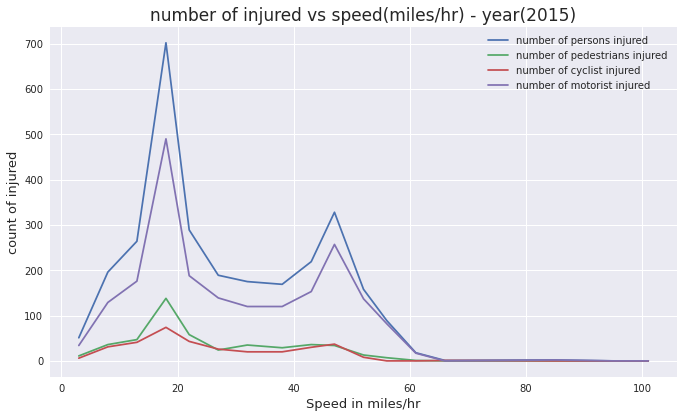

In [859]:
injrd_cols_to_lineplot = ['number_of_persons_injured', 'number_of_pedestrians_injured',    \
                    'number_of_cyclist_injured', 'number_of_motorist_injured']
year = 2015
title = 'number of injured vs speed(miles/hr) - year(' + str(year) + ')'
crash_plt = multiline_plot(crash_speed_2015_grp, 'Speed', injrd_cols_to_lineplot, title=title, xlabel='')

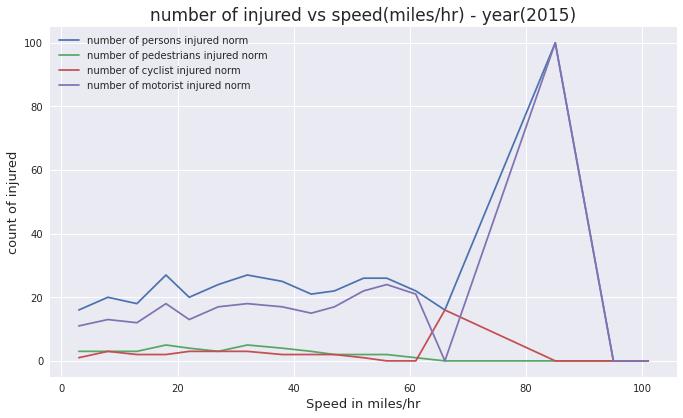

In [863]:
injrd_norm_cols_to_lineplot = ['number_of_persons_injured_norm', 'number_of_pedestrians_injured_norm',    \
                    'number_of_cyclist_injured_norm', 'number_of_motorist_injured_norm']
year = 2015
title = 'number of injured vs speed(miles/hr) - year(' + str(year) + ')'
crash_plt = multiline_plot(crash_speed_2015_grp, 'Speed', injrd_norm_cols_to_lineplot, title=title, xlabel='')

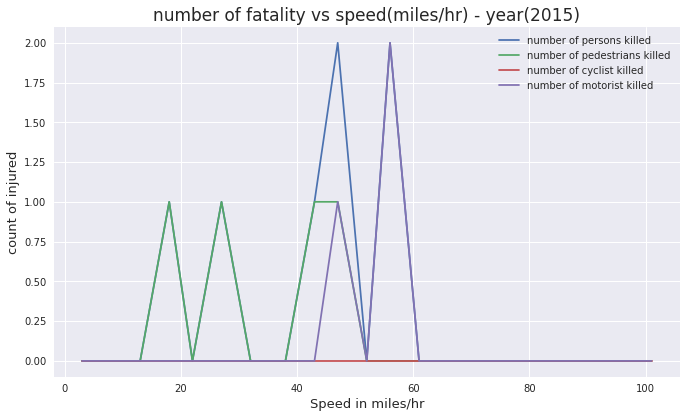

In [864]:
killed_cols_to_lineplot = ['number_of_persons_killed', 'number_of_pedestrians_killed',    \
                    'number_of_cyclist_killed', 'number_of_motorist_killed']
year = 2015
title = 'number of fatality vs speed(miles/hr) - year(' + str(year) + ')'
fatal_plt = multiline_plot(crash_speed_2015_grp, 'Speed', killed_cols_to_lineplot, title=title, xlabel='')

In [173]:
# crash_gdf_speed_region.columns
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       crashes: 877.1 MiB
               crahes_speed_df: 639.4 MiB
             crahes_speed_2015: 639.4 MiB
             crahes_speed_2016: 639.4 MiB
                   crashes_gdf: 614.6 MiB
            traffic_speed_2016: 298.2 MiB
            traffic_speed_2015: 235.3 MiB
                traffic_volume: 14.2 MiB
                   traffic_vol: 10.8 MiB
                          _130:  8.6 MiB
